# Add more things than plate fiducials that can be useful for parameter constraint

### Oct. 30th, 2018
In the last meeting, Michael suggested the following things:
- If one uses the laser then one can measure the distance between metrology camera and plate within 20 mm(?; it might be less than 1mm) error. This will give an independent constraint on ||Tc||.
- If one uses the three metrology fibers in a Starbug near the image center, it can give an independent contraint on fc ad cc[].
- If one uses guide bundles inside the field, it may be able to give a better constraint on the high-order kc[] (e.g., kc[1] and kc[4]).

By assuming that, let's add the following things:
- Let's assume that the distance between metrology camera and plate (hence ||Tc||) is acculately known. However, it does not automatically mean that the entire Tc[] is acculately known. Let's assume that the smaller components of Tc[] still have +/-5% error.
- The second and third parts can be simulated at once --- let's simulate $N (\sim 10 - 10^2)$ guide bundles and three metrology fibers around them. Let's assume that (1) we already know the **centroid** positions of guide bundles, and (2) we don't know the positions of their **metrology fibers**. Also, let's assume that all guide bundles are well separated so that there is no chance to confuse where a given metrology fiber belongs to. Then (1) the reconstructed plate positions of metrology fibers at the guide bundle that is **closest to the image center** will be used to constrain fc, cc[] and kc[0] (...but how?) (2) together with plate fiducials, the centroids of guide bundles are used to constrain all parameters.

If we really use metrology fibers in the guide bundle closest to the image center, then it should be applied **first and (maybe) by it alone**, since the guide bundles are also affected by the high-order kc[].

## 1. Guide bundle at the **EXACT** image center

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import interpolate as itpl

In [22]:
def ReadPlatePos(prefix):
    rawData = np.genfromtxt("../08_mod01_07_dataWithROCCorrection/%s.dat" % (prefix))
    arrPlt,arrPix = rawData[:,2:5],rawData[:,5:7]
    return arrPlt

In [2]:
class Parameter:
    def __init__(self):
        self.ROC = 3265.
        self.DFOV = 1200.
        self.fc = 7246.376812
        self.Tc = np.array([0,-299.408892,-3261.955597])
        self.Rc = np.array([0,0,0])	# Rotation in units of rad...
        self.kc = np.array([-0.2,0,0,0,0])		# radial distortion coefficients
        self.cc = np.array([1224,1025])
        
        
def GetFiducialParameter(prefix):
    params = Parameter()  # See Parameter::__init__ for the definition of other parameters
    params.Rc = np.array([0,0,0])	# Rotation in units of rad... see below
    
    if prefix == "MANIFEST_sim_001_coord_data_camera-1":
        params.Rc = np.array([0.097242,-0.097242,1.568608])
    elif prefix == "MANIFEST_sim_001_coord_data_camera-2":
        params.Rc = np.array([0.120983,0.032417,-0.522923])
    elif prefix == "MANIFEST_sim_001_coord_data_camera-3":
        params.Rc = np.array([0.043415,0.162026,-2.613643])
        
    return params

In [7]:
def ChangeFiducialParameter(params,valType,valPercent):
    if valPercent < -5 or valPercent > 5:
        print("Error: value error should be between -5% ~ +5%!!!")
        return params
    frac = 1.+valPercent*0.01
    
    newParams = Parameter()
    newParams.fc = params.fc
    newParams.Tc = np.copy(params.Tc)
    newParams.Rc = np.copy(params.Rc)
    newParams.kc = np.copy(params.kc)
    newParams.cc = np.copy(params.cc)
    
    if valType == "fc":
        newParams.fc *= frac
    elif valType[:2] == "Tc":
        TcTotSq = newParams.Tc[0]**2 + newParams.Tc[1]**2 + newParams.Tc[2]**2
        if valType[2] == '0':
            newParams.Tc[0] = 0.01*valPercent*newParams.Tc[1]
        else:
            newParams.Tc[1] *= frac
        newParams.Tc[2] = np.sqrt(TcTotSq - newParams.Tc[0]**2 - newParams.Tc[1]**2)
    elif valType[:2] == "Rc":
        newParams.Rc[np.int(valType[2])] *= frac
    elif valType[:2] == "kc":
        if valType[2] == '0':
            newParams.kc[0] *= frac
        else:
            newParams.kc[np.int(valType[2])] = 1E-6*valPercent
    elif valType[:2] == "cc":
        newParams.cc[np.int(valType[2])] *= frac
    else:
        print("Error: type should be either (fc, Tc#, Rc#, kc#, cc#)")
    return newParams

In [4]:
def ConvertPlateToPix(arrPlate,params):
    
    cameraMatrix = np.array([[params.fc,0,params.cc[0]],[0,params.fc,params.cc[1]],[0,0,1]])
    arrPix,jac = cv2.projectPoints(np.copy(arrPlate),params.Rc,params.Tc,cameraMatrix,params.kc)
    arrPix = arrPix.reshape(-1,2)
    
    return arrPix

"""
Returns two maps : (Xpix,Ypix) ---> (Xplt) and (Xpix,Ypix) ---> (Yplt)
from given plate alignment/camera distortion parameters and spline interpolation setup.

Input:
	- params : Parameter() object that contains plate alignment/camera distortion parameters.
	- kind : kind of spline interpolation ('linear','cubic','quintic')
	- Ngrid : number of grids from -DFOV/2 to +DFOV/2

Output:
	- mapXYpixToXplt : mapping function of (Xpix,Ypix) ---> (Xplt)
	- mapXYpixToYplt : mapping function of (Xpix,Ypix) ---> (Yplt)
"""
def MakeMapPixToPlate(params,kind,Ngrid):
    
    """Step 1. Make the grid for X_plate and Y_plate"""
    Xplt,Yplt = np.mgrid[-params.DFOV*0.5:params.DFOV*0.5:Ngrid*1j,-params.DFOV*0.5:params.DFOV*0.5:Ngrid*1j]
    Xplt,Yplt = Xplt.flatten(),Yplt.flatten()
    #print("Dimension of Xplt : ",Xplt.shape)

    """Step 2. Calculate the Z_plate for each X_plate and Y_plate, and stack it"""
    Zplt = np.sqrt(params.ROC**2-Xplt**2-Yplt**2) - params.ROC
    XYZplt = np.vstack([Xplt,Yplt,Zplt]).T
    #print("Dimension of XYZplt : ",XYZplt.shape)

    """Step 3. Project 3D points to an image plane, by using OpenCV"""
    cameraMatrix = np.array([[params.fc,0,params.cc[0]],[0,params.fc,params.cc[1]],[0,0,1]])
    XYpix,Jacob = cv2.projectPoints(XYZplt,params.Rc,params.Tc,cameraMatrix,params.kc)
    XYpix = XYpix.reshape(-1,2)
    #print("Dimension of XYpix : ",XYpix.shape)

    """Step 4. Construct maps to find (Xpix,Ypix) ---> (Xplt) and (Xpix,Ypix) ---> (Yplt)"""
    mapXYpixToXplt = itpl.interp2d(XYpix[:,0],XYpix[:,1],Xplt,kind=kind)
    mapXYpixToYplt = itpl.interp2d(XYpix[:,0],XYpix[:,1],Yplt,kind=kind)

    return mapXYpixToXplt,mapXYpixToYplt

    
    
"""
Returns X/Y/Z plate position from a given X/Y camera position and mappin functions.

Input:
	- arrPixPos : X/Y camera position in units of px.
	- mapXYpixToXplt : mapping function of (Xpix,Ypix) ---> (Xplt)
	- mapXYpixToYplt : mapping function of (Xpix,Ypix) ---> (Yplt)
	- params : Parameter() object that contains plate alignment/camera distortion parameters.

Output:
	- XYZplt : X/Y/Z plate position in units of mm.
"""
def ConvertPixToPlate(arrPix,mapXYpixToXplt,mapXYpixToYplt,params):

    """Step 1. Get the Xplt and Yplt"""
    Xplt = np.array([mapXYpixToXplt(x,y) for x,y in arrPix]).flatten()
    Yplt = np.array([mapXYpixToYplt(x,y) for x,y in arrPix]).flatten()
    #print("Dimension of Xplt : ",Xplt.shape)

    """Step 2. Get the Zplt from Xplt and Yplt, and stack it"""
    Zplt = np.sqrt(params.ROC**2-Xplt**2-Yplt**2) - params.ROC
    XYZplt = np.vstack([Xplt,Yplt,Zplt]).T
    #print("Dimension of XYZplt : ",XYZplt.shape)

    return XYZplt

In [5]:
def MakePlateFiducial(N,radius,ROC):
    arrTheta = np.arange(N)*(2.*np.pi/N)
    arrX,arrY = radius*np.cos(arrTheta),radius*np.sin(arrTheta)
    arrZ = np.sqrt(ROC**2-arrX**2-arrY**2) - ROC
    
    return np.vstack([arrX,arrY,arrZ]).T

In [31]:
from scipy import optimize as opt

def RecalibrateParameter(arrPlate,arrPix,paramsFid):
    # Here, let's consider STAGGERED fitting of plate alignment parameters and camera calibration parameters
    # 1. Initialize two types of parameters by using fiducial choice
    plateParam = np.concatenate((paramsFid.Tc[:-1],paramsFid.Rc))
    camParam = np.concatenate((np.array([paramsFid.fc]),paramsFid.kc,paramsFid.cc))
    
    plateParamFid,camParamFid = np.copy(plateParam),np.copy(camParam)
    param = np.concatenate((plateParam,camParam))
    
    plateLowPercent,plateHighPercent = plateParamFid*0.95,plateParamFid*1.05
    camLowPercent,camHighPercent = camParamFid*0.95,camParamFid*1.05
    plateLowBound = np.minimum(plateLowPercent,plateHighPercent) + np.array([-np.abs(paramsFid.Tc[1])*0.05,0,0,0,np.abs(paramsFid.Rc[2]*0.03)])
    plateHighBound = np.maximum(plateLowPercent,plateHighPercent) + np.array([np.abs(paramsFid.Tc[1])*0.05,0,0,0,-np.abs(paramsFid.Rc[2]*0.03)])
    camLowBound = np.minimum(camLowPercent,camHighPercent) + np.array([0,0,-5e-6,-5e-6,-5e-6,-5e-6,0,0])
    camHighBound = np.maximum(camLowPercent,camHighPercent) + np.array([0,0,5e-6,5e-6,5e-6,5e-6,0,0])
    
    # 2. Fit until it converges to something....
    iTrial = 0
    while iTrial < 1000:
        plateParamOld,camParamOld,paramOld = np.copy(plateParam),np.copy(camParam),np.copy(param)
        plateParam = opt.least_squares(ResidueChangePlate,plateParamOld,
                                     args=(arrPlate,arrPix,camParamOld),
                                       bounds=(plateLowBound,plateHighBound),
                                      ftol=1E-16,xtol=1E-16).x
        camParam = opt.least_squares(ResidueChangeCam,camParamOld,
                                    args=(arrPlate,arrPix,plateParam),
                                    bounds=(camLowBound,camHighBound),
                                    ftol=1E-16,xtol=1E-16).x
        iTrial += 1
        param = np.concatenate((plateParam,camParam))
        
        if iTrial < 3:
            continue
        error = np.nanmax(np.abs(param-paramOld)/np.abs(paramOld))
        if error < 1E-6:
            break
        if iTrial % 100 == 0:
            print(" ---> Trial %d : max. parameter error is %f percent" % (iTrial,error*100.))
            
    print(" ---> Trial %d : parameter converged (or maximum trial reached)" % (iTrial))
            
    return ConstructParameter(plateParam,camParam)


def ConstructParameter(plateParam,camParam):
    params = Parameter()
    TcSq = params.Tc[0]**2 + params.Tc[1]**2 + params.Tc[2]**2
    params.Tc[:2],params.Rc = plateParam[:2],plateParam[2:]
    params.Tc[2] = np.sqrt(TcSq - params.Tc[0]**2 - params.Tc[1]**2)
    params.fc,params.kc,params.cc = camParam[0],camParam[1:6],camParam[6:]
    return params

def ResidueChangePlate(plateParam,arrPlate,arrPix,camParam):
    params = ConstructParameter(plateParam,camParam)
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

def ResidueChangeCam(camParam,arrPlate,arrPix,plateParam):
    params = ConstructParameter(plateParam,camParam)
    arrEstPix = ConvertPlateToPix(arrPlate,params)
    return np.sqrt((arrEstPix[:,0]-arrPix[:,0])**2 + (arrEstPix[:,1]-arrPix[:,1])**2)

In [8]:
def CollectPixWithinFrame(arrOld,width,height):
    indx = (arrOld[:,0] >= 0) & (arrOld[:,0] < width) & (arrOld[:,1] >= 0) & (arrOld[:,1] < height)
    return arrOld[indx,:]

def GetFiducialSubset(arrPlate,arrPixFid,arrPixNew):
    arrPlateSub = []
    for pixNew in arrPixNew:
        diffSq = (arrPixFid[:,0]-pixNew[0])**2 + (arrPixFid[:,1]-pixNew[1])**2
        indx = np.argmin(diffSq)
        arrPlateSub.append(arrPlate[indx,:])
        
    return np.array(arrPlateSub)

In [16]:
def ChangeFullFiducialParameter(paramOrig,arrPercent):
    params = ChangeFiducialParameter(paramOrig,"Tc0",arrPercent[0])
    params = ChangeFiducialParameter(params,"Tc1",arrPercent[1])
    params = ChangeFiducialParameter(params,"Rc0",arrPercent[2])
    params = ChangeFiducialParameter(params,"Rc1",arrPercent[3])
    params = ChangeFiducialParameter(params,"Rc2",arrPercent[4])
    params = ChangeFiducialParameter(params,"fc",arrPercent[5])
    params = ChangeFiducialParameter(params,"kc0",arrPercent[6])
    params = ChangeFiducialParameter(params,"kc1",arrPercent[7])
    params = ChangeFiducialParameter(params,"kc2",arrPercent[8])
    params = ChangeFiducialParameter(params,"kc3",arrPercent[9])
    params = ChangeFiducialParameter(params,"kc4",arrPercent[10])
    params = ChangeFiducialParameter(params,"cc0",arrPercent[11])
    params = ChangeFiducialParameter(params,"cc1",arrPercent[12])
    
    return params

In [14]:
"""
Generate the plate positions of three metrology fibers around the given guide bundle, rotated with **angle**.
"""
def GenerateMetrology(posGuideBundle,angle,ROC):
    rad,angle12,angle23 = 3.065,77.8,102.2
    
    result = []
    for addAngle in [0,angle12,angle12+angle23]:
        theta = (angle+addAngle)*np.pi/180.
        posX,posY = posGuideBundle[0,0] + rad*np.cos(theta),posGuideBundle[0,1] + rad*np.sin(theta)
        result.append([posX,posY,np.sqrt(ROC**2-posX**2-posY**2)-ROC])
        
    return np.array(result)

In [18]:
"""
Recalibrate a subset of parameters(fc,cc[],kc[1]) from pixel positions of metrology fibers.
Since we don't know their exact plate positions, we use their relative positions.
"""
def RecalibrateParameterFromMet(pixMet,paramFid):
    # 1. Initialize sub-parameters by using fiducial choice
    subParamFid = np.array([paramFid.fc,paramFid.cc[0],paramFid.cc[1],paramFid.kc[0]])

    # 2. Define the boundary
    lowPercent,highPercent = subParamFid*0.95,subParamFid*1.05
    lowBound,upBound = np.minimum(lowPercent,highPercent),np.maximum(lowPercent,highPercent)
    
    # 3. Fit the distance between three metrology fibers
    subParam = opt.least_squares(ResidueMetrology,subParamFid,
                                args=(pixMet,paramFid),bounds=(lowBound,upBound),
                                ftol=1E-16,xtol=1E-16).x
            
    return subParam


def ResidueMetrology(subParam,pixMet,paramFid):
    rad,angleA,angleB,angleC = 3.065,77.8,102.2,180.
    distFid = 2.*rad*np.array([np.sin(angleA*np.pi/360.),np.sin(angleB*np.pi/360.),np.sin(angleC*np.pi/360.)])
    
    params = ChangeMetParam(paramFid,subParam)
    mapXYtoX,mapXYtoY = MakeMapPixToPlate(params,"quintic",51)
    plateMet = ConvertPixToPlate(pixMet,mapXYtoX,mapXYtoY,params)
    dist = np.sort([np.sqrt((plateMet[0,0]-plateMet[1,0])**2 + (plateMet[0,1]-plateMet[1,1])**2),
                    np.sqrt((plateMet[1,0]-plateMet[2,0])**2 + (plateMet[1,1]-plateMet[2,1])**2),
                    np.sqrt((plateMet[2,0]-plateMet[0,0])**2 + (plateMet[2,1]-plateMet[0,1])**2)])

    return np.sqrt((dist[0]-distFid[0])**2 + (dist[1]-distFid[1])**2 + (dist[2]-distFid[2])**2)

def ChangeMetParam(paramFid,subParam):
    params = Parameter()
    params.fc = subParam[0]
    params.Tc = np.copy(paramFid.Tc)
    params.Rc = np.copy(paramFid.Rc)
    params.kc = np.copy(paramFid.kc)
    params.kc[0] = subParam[3]
    params.cc = np.copy(subParam[1:3])

    return params

In [11]:
def SaveOutput(arrO,arrFcE,arrCcAE,arrCcBE,arrKcAE,filename):
    fp = open(filename,"w")
    fp.write("# COL 1-2 : Original/Estimated errors of fc in percent\n")
    fp.write("# COL 3-4 : Original/Estimated errors of cc[1] in percent\n")
    fp.write("# COL 5-6 : Original/Estimated errors of cc[2] in percent\n")
    fp.write("# COL 7-8 : Original/Estimated errors of kc[1] in percent\n")
    fp.write("# COL 9-10 : Original errors of Tc[] in percent\n")
    fp.write("# COL 11-13 : Original errors of Rc[] in percent\n")
    fp.write("# COL 14-17 : Original errors of kc[2-5] in percent\n")
    for o,fcE,ccAE,ccBE,kcAE in zip(arrO,arrFcE,arrCcAE,arrCcBE,arrKcAE):
        fp.write("%f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f %f\n"
                % (o[5],fcE,o[11],ccAE,o[12],ccBE,o[6],kcAE,
                  o[0],o[1],o[2],o[3],o[4],o[7],o[8],o[9],o[10]))
        
    fp.close()

Let's assume that we know the guide bundle lays at the **EXACT** image center, if all plate alignment and camera calibration parameters are as fiducial. Then let's change Tc[], Rc[], fc, kc[], cc[] and check how the 3 distances between metrology fibers around the bundle can help the constraining fc, cc[] and kc[0].

In [ ]:
%matplotlib inline

WIDTH,HEIGHT = 2448,2050
# Get the fiducial choice for camera 1
prefix = "MANIFEST_sim_001_coord_data_camera-1"
params = GetFiducialParameter(prefix)

# Get the plate position of the guide bundle that lays the image center
mapXYtoXfid,mapXYtoYfid = MakeMapPixToPlate(params,"quintic",51)
pixGB = (np.array([WIDTH,HEIGHT])*0.5).reshape(1,2)
plateGB = ConvertPixToPlate(pixGB,mapXYtoXfid,mapXYtoYfid,params)
plateMet = GenerateMetrology(plateGB,0,params.ROC)

# Parameter variations that changes 13 parameters (2 for Tc[], 3 for Rc[], 1 for fc, 5 for kc[], 2 for cc[])
Nvar = 10
randVar = np.random.rand(Nvar,13)*10-5.
randVar[:,4] *= 0.4  # Rc[2] should be far less than 2%
arrFcO,arrCcAO,arrCcBO,arrKcAO = randVar[:,5],randVar[:,11],randVar[:,12],randVar[:,6]
arrFcE,arrCcAE,arrCcBE,arrKcAE = [],[],[],[]

for rv,ivar in zip(randVar,range(1,Nvar+1)):
    newParams = ChangeFullFiducialParameter(params,rv)
    pixMet = ConvertPlateToPix(plateMet,newParams)
    
    estSubParams = RecalibrateParameterFromMet(pixMet,params)
    arrFcE.append(estSubParams[0])
    arrCcAE.append(estSubParams[1])
    arrCcBE.append(estSubParams[2])
    arrKcAE.append(estSubParams[3])
    
    print("Done round %d" % (ivar))
    
plt.clf()
fig,axs = plt.subplots(1,4,figsize=(17,4))
for ax,orig,est,valtype in zip(axs,[arrFcO,arrCcAO,arrCcBO,arrKcAO],
                              [arrFcE,arrCcAE,arrCcBE,arrKcAE],
                              ["fc","cc[1]","cc[2]","kc[1]"]):
    ax.scatter(orig,est,s=1,rasterized=True)
    ax.set_title(valtype)
    ax.set_xlabel("Original error [%]")
    ax.set_ylabel("Estimated error [%]")
            
plt.savefig("centerGuideBundle.pdf",bbox_inches="tight",dpi=150)

SaveOutput(randVar,arrFcE,arrCcAE,arrCcBE,arrKcAE,"centerGuideBundle.dat")

... Too slow!!!
Let's check it later.

On the other hand, if ||Tc|| is fixed, then can't we solve most of the parameter degeneracies only by using plate fiducials?

## 2. Plate fiducials only (fixing ||Tc||)

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


 ---> Trial 46 : parameter converged (or maximum trial reached)
 ---> Trial 29 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 14 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 100 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 58 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 59 : parameter converged (or maximum trial reached)
 ---> Trial 79 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 79 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximu

<Figure size 432x288 with 0 Axes>

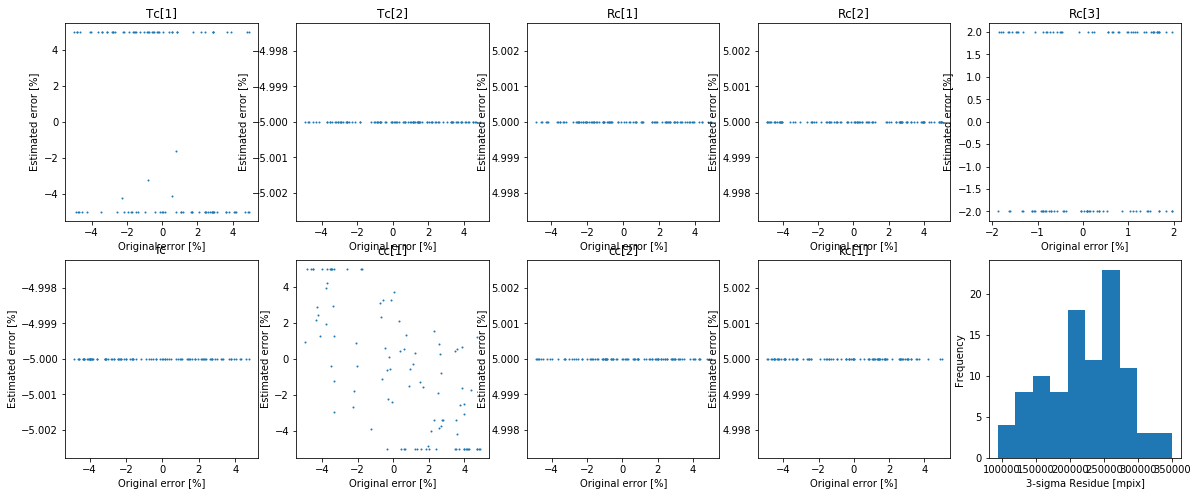

In [44]:
%matplotlib inline

# Get the fiducial choice for camera 1
prefix = "MANIFEST_sim_001_coord_data_camera-1"
params = GetFiducialParameter(prefix)
plateTarget = ReadPlatePos(prefix)
plateFiducial = MakePlateFiducial(100,params.DFOV*0.5,params.ROC)

pixFiducialFid = ConvertPlateToPix(plateFiducial,params)

WIDTH,HEIGHT = 2448,2050

plt.clf()
fig,axs = plt.subplots(2,5,figsize=(20,8))
axs = axs.flatten()

# Parameter variations that changes 13 parameters (2 for Tc[], 3 for Rc[], 1 for fc, 5 for kc[], 2 for cc[])
Nvar = 100
randVar = np.random.rand(Nvar,13)*10-5.
randVar[:,4] *= 0.4  # Rc[2] should be far less than 2%

arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO = randVar[:,0],randVar[:,1],randVar[:,2],randVar[:,3],randVar[:,4],randVar[:,5],randVar[:,11],randVar[:,12],randVar[:,6]
arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE = [],[],[],[],[],[],[],[],[]

errBudget = []
for rv,ivar in zip(randVar,range(1,Nvar+1)):
    newParams = ChangeFullFiducialParameter(params,rv)
    pixTarget = ConvertPlateToPix(plateTarget,newParams)
    pixFiducial = ConvertPlateToPix(plateFiducial,newParams)
        
    pixFiducialSub = CollectPixWithinFrame(pixFiducial,WIDTH,HEIGHT)
    plateFiducialSub = GetFiducialSubset(plateFiducial,pixFiducialFid,pixFiducialSub)
    
    estParams = RecalibrateParameter(plateFiducialSub,pixFiducialSub,params)
    arrTcAE.append(estParams.Tc[0]/params.Tc[1]*100)
    arrTcBE.append((estParams.Tc[1]-params.Tc[1])/params.Tc[1]*100)
    arrRcAE.append((estParams.Rc[0]-params.Rc[0])/params.Rc[0]*100)
    arrRcBE.append((estParams.Rc[1]-params.Rc[1])/params.Rc[1]*100)
    arrRcCE.append((estParams.Rc[2]-params.Rc[2])/params.Rc[2]*100)
    arrFcE.append((estParams.fc-params.fc)/params.fc*100)
    arrCcAE.append((estParams.cc[0]-params.cc[0])/params.cc[0]*100)
    arrCcBE.append((estParams.cc[1]-params.cc[1])/params.cc[1]*100)
    arrKcAE.append((estParams.kc[0]-params.kc[0])/params.kc[0]*100)

    estPixTarget = ConvertPlateToPix(plateTarget,estParams)
    residues = np.sqrt((estPixTarget[:,0]-pixTarget[:,0])**2 + (estPixTarget[:,1]-pixTarget[:,1])**2)*1E3
    
    errBudget.append(np.percentile(residues,99.865))


for ax,orig,est,valType in zip(axs[:-1],
                                [arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO],
                              [arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE],
                              ["Tc[1]","Tc[2]","Rc[1]","Rc[2]","Rc[3]","fc","cc[1]","cc[2]","kc[1]"]):
    ax.scatter(orig,est,s=1,rasterized=True)
    ax.set_title(valType)
    ax.set_xlabel("Original error [%]")
    ax.set_ylabel("Estimated error [%]")
    
axs[-1].hist(errBudget)
axs[-1].set_xlabel("3-sigma Residue [mpix]")
axs[-1].set_ylabel("Frequency")
plt.savefig("plateFiducialOnly.pdf",bbox_inches="tight",dpi=150)

In [33]:
from scipy import optimize as opt

def RecalibrateParameterCamFirst(arrPlate,arrPix,paramsFid):
    # Here, let's consider STAGGERED fitting of plate alignment parameters and camera calibration parameters
    # 1. Initialize two types of parameters by using fiducial choice
    plateParam = np.concatenate((paramsFid.Tc[:-1],paramsFid.Rc))
    camParam = np.concatenate((np.array([paramsFid.fc]),paramsFid.kc,paramsFid.cc))
    
    plateParamFid,camParamFid = np.copy(plateParam),np.copy(camParam)
    param = np.concatenate((plateParam,camParam))
    
    plateLowPercent,plateHighPercent = plateParamFid*0.95,plateParamFid*1.05
    camLowPercent,camHighPercent = camParamFid*0.95,camParamFid*1.05
    plateLowBound = np.minimum(plateLowPercent,plateHighPercent) + np.array([-np.abs(paramsFid.Tc[1])*0.05,0,0,0,np.abs(paramsFid.Rc[2])*0.03])
    plateHighBound = np.maximum(plateLowPercent,plateHighPercent) + np.array([np.abs(paramsFid.Tc[1])*0.05,0,0,0,-np.abs(paramsFid.Rc[2])*0.03])
    camLowBound = np.minimum(camLowPercent,camHighPercent) + np.array([0,0,-5e-6,-5e-6,-5e-6,-5e-6,0,0])
    camHighBound = np.maximum(camLowPercent,camHighPercent) + np.array([0,0,5e-6,5e-6,5e-6,5e-6,0,0])
    
    # 2. Fit until it converges to something....
    iTrial = 0
    while iTrial < 1000:
        plateParamOld,camParamOld,paramOld = np.copy(plateParam),np.copy(camParam),np.copy(param)
        camParam = opt.least_squares(ResidueChangeCam,camParamOld,
                                    args=(arrPlate,arrPix,plateParamOld),
                                    bounds=(camLowBound,camHighBound),
                                    ftol=1E-16,xtol=1E-16).x
        plateParam = opt.least_squares(ResidueChangePlate,plateParamOld,
                                     args=(arrPlate,arrPix,camParam),
                                       bounds=(plateLowBound,plateHighBound),
                                      ftol=1E-16,xtol=1E-16).x

        iTrial += 1
        param = np.concatenate((plateParam,camParam))
        
        if iTrial < 3:
            continue
        error = np.nanmax(np.abs(param-paramOld)/np.abs(paramOld))
        if error < 1E-6:
            break
        if iTrial % 100 == 0:
            print(" ---> Trial %d : max. parameter error is %f percent" % (iTrial,error*100.))
            
    print(" ---> Trial %d : parameter converged (or maximum trial reached)" % (iTrial))
            
    return ConstructParameter(plateParam,camParam)


C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


 ---> Trial 66 : parameter converged (or maximum trial reached)
 ---> Trial 100 : max. parameter error is 1.851211 percent
 ---> Trial 103 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 95 : parameter converged (or maximum trial reached)
 ---> Trial 81 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 6 : parameter converged (or maximum trial reached)
 ---> Trial 100 : max. parameter error is 1.653652 percent
 ---> Trial 113 : parameter converged (or maximum trial reached)
 ---> Trial 82 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 79 : parameter converged (or maximum trial reached)
 ---> Trial 87 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial

<Figure size 432x288 with 0 Axes>

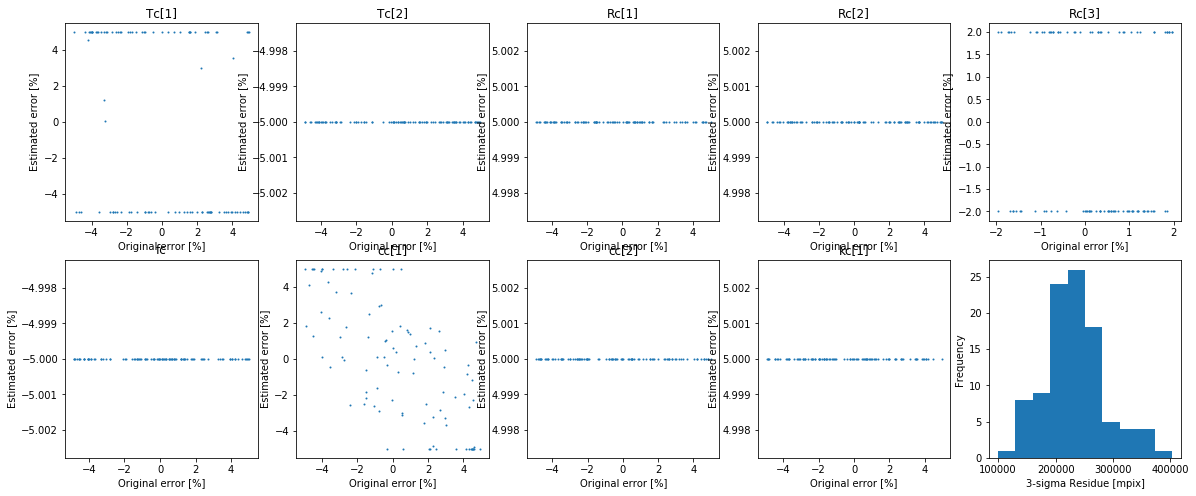

In [43]:
%matplotlib inline

# Get the fiducial choice for camera 1
prefix = "MANIFEST_sim_001_coord_data_camera-1"
params = GetFiducialParameter(prefix)
plateTarget = ReadPlatePos(prefix)
plateFiducial = MakePlateFiducial(100,params.DFOV*0.5,params.ROC)

pixFiducialFid = ConvertPlateToPix(plateFiducial,params)

WIDTH,HEIGHT = 2448,2050

plt.clf()
fig,axs = plt.subplots(2,5,figsize=(20,8))
axs = axs.flatten()

# Parameter variations that changes 13 parameters (2 for Tc[], 3 for Rc[], 1 for fc, 5 for kc[], 2 for cc[])
Nvar = 100
randVar = np.random.rand(Nvar,13)*10-5.
randVar[:,4] *= 0.4  # Rc[2] should be far less than 2%

arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO = randVar[:,0],randVar[:,1],randVar[:,2],randVar[:,3],randVar[:,4],randVar[:,5],randVar[:,11],randVar[:,12],randVar[:,6]
arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE = [],[],[],[],[],[],[],[],[]

errBudget = []
for rv,ivar in zip(randVar,range(1,Nvar+1)):
    newParams = ChangeFullFiducialParameter(params,rv)
    pixTarget = ConvertPlateToPix(plateTarget,newParams)
    pixFiducial = ConvertPlateToPix(plateFiducial,newParams)
        
    pixFiducialSub = CollectPixWithinFrame(pixFiducial,WIDTH,HEIGHT)
    plateFiducialSub = GetFiducialSubset(plateFiducial,pixFiducialFid,pixFiducialSub)
    
    estParams = RecalibrateParameterCamFirst(plateFiducialSub,pixFiducialSub,params)
    arrTcAE.append(estParams.Tc[0]/params.Tc[1]*100)
    arrTcBE.append((estParams.Tc[1]-params.Tc[1])/params.Tc[1]*100)
    arrRcAE.append((estParams.Rc[0]-params.Rc[0])/params.Rc[0]*100)
    arrRcBE.append((estParams.Rc[1]-params.Rc[1])/params.Rc[1]*100)
    arrRcCE.append((estParams.Rc[2]-params.Rc[2])/params.Rc[2]*100)
    arrFcE.append((estParams.fc-params.fc)/params.fc*100)
    arrCcAE.append((estParams.cc[0]-params.cc[0])/params.cc[0]*100)
    arrCcBE.append((estParams.cc[1]-params.cc[1])/params.cc[1]*100)
    arrKcAE.append((estParams.kc[0]-params.kc[0])/params.kc[0]*100)

    estPixTarget = ConvertPlateToPix(plateTarget,estParams)
    residues = np.sqrt((estPixTarget[:,0]-pixTarget[:,0])**2 + (estPixTarget[:,1]-pixTarget[:,1])**2)*1E3
    
    errBudget.append(np.percentile(residues,99.865))


for ax,orig,est,valType in zip(axs[:-1],
                                [arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO],
                              [arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE],
                              ["Tc[1]","Tc[2]","Rc[1]","Rc[2]","Rc[3]","fc","cc[1]","cc[2]","kc[1]"]):
    ax.scatter(orig,est,s=1,rasterized=True)
    ax.set_title(valType)
    ax.set_xlabel("Original error [%]")
    ax.set_ylabel("Estimated error [%]")
    
axs[-1].hist(errBudget)
axs[-1].set_xlabel("3-sigma Residue [mpix]")
axs[-1].set_ylabel("Frequency")
plt.savefig("plateFiducialOnly_camFirst.pdf",bbox_inches="tight",dpi=150)

Wow, this is really a bad news.
If we allow varying all parameters,then all parameters change so randomly, and $3\sigma$ residue is so large.

### Oct. 31st, 2018

## 3. Lowering allowed error range
Probably the $\pm 5\%$ range was too large range to allow. If we narrow it down to $\pm 3\%$ and $\pm 1\%$, can we get the reasonable fit just by using plate fiducials?

### (1) $\pm 3\%$

In [45]:
def RecalibrateParameter(arrPlate,arrPix,paramsFid):
    # Here, let's consider STAGGERED fitting of plate alignment parameters and camera calibration parameters
    # 1. Initialize two types of parameters by using fiducial choice
    plateParam = np.concatenate((paramsFid.Tc[:-1],paramsFid.Rc))
    camParam = np.concatenate((np.array([paramsFid.fc]),paramsFid.kc,paramsFid.cc))
    
    plateParamFid,camParamFid = np.copy(plateParam),np.copy(camParam)
    param = np.concatenate((plateParam,camParam))
    
    plateLowPercent,plateHighPercent = plateParamFid*0.97,plateParamFid*1.03
    camLowPercent,camHighPercent = camParamFid*0.97,camParamFid*1.03
    plateLowBound = np.minimum(plateLowPercent,plateHighPercent) + np.array([-np.abs(paramsFid.Tc[1])*0.03,0,0,0,np.abs(paramsFid.Rc[2]*0.018)])
    plateHighBound = np.maximum(plateLowPercent,plateHighPercent) + np.array([np.abs(paramsFid.Tc[1])*0.03,0,0,0,-np.abs(paramsFid.Rc[2]*0.018)])
    camLowBound = np.minimum(camLowPercent,camHighPercent) + np.array([0,0,-3e-6,-3e-6,-3e-6,-3e-6,0,0])
    camHighBound = np.maximum(camLowPercent,camHighPercent) + np.array([0,0,3e-6,3e-6,3e-6,3e-6,0,0])
    
    # 2. Fit until it converges to something....
    iTrial = 0
    while iTrial < 1000:
        plateParamOld,camParamOld,paramOld = np.copy(plateParam),np.copy(camParam),np.copy(param)
        plateParam = opt.least_squares(ResidueChangePlate,plateParamOld,
                                     args=(arrPlate,arrPix,camParamOld),
                                       bounds=(plateLowBound,plateHighBound),
                                      ftol=1E-16,xtol=1E-16).x
        camParam = opt.least_squares(ResidueChangeCam,camParamOld,
                                    args=(arrPlate,arrPix,plateParam),
                                    bounds=(camLowBound,camHighBound),
                                    ftol=1E-16,xtol=1E-16).x
        iTrial += 1
        param = np.concatenate((plateParam,camParam))
        
        if iTrial < 3:
            continue
        error = np.nanmax(np.abs(param-paramOld)/np.abs(paramOld))
        if error < 1E-6:
            break
        if iTrial % 100 == 0:
            print(" ---> Trial %d : max. parameter error is %f percent" % (iTrial,error*100.))
            
    print(" ---> Trial %d : parameter converged (or maximum trial reached)" % (iTrial))
            
    return ConstructParameter(plateParam,camParam)

def RecalibrateParameterCamFirst(arrPlate,arrPix,paramsFid):
    # Here, let's consider STAGGERED fitting of plate alignment parameters and camera calibration parameters
    # 1. Initialize two types of parameters by using fiducial choice
    plateParam = np.concatenate((paramsFid.Tc[:-1],paramsFid.Rc))
    camParam = np.concatenate((np.array([paramsFid.fc]),paramsFid.kc,paramsFid.cc))
    
    plateParamFid,camParamFid = np.copy(plateParam),np.copy(camParam)
    param = np.concatenate((plateParam,camParam))
    
    plateLowPercent,plateHighPercent = plateParamFid*0.97,plateParamFid*1.03
    camLowPercent,camHighPercent = camParamFid*0.97,camParamFid*1.03
    plateLowBound = np.minimum(plateLowPercent,plateHighPercent) + np.array([-np.abs(paramsFid.Tc[1])*0.03,0,0,0,np.abs(paramsFid.Rc[2])*0.018])
    plateHighBound = np.maximum(plateLowPercent,plateHighPercent) + np.array([np.abs(paramsFid.Tc[1])*0.03,0,0,0,-np.abs(paramsFid.Rc[2])*0.018])
    camLowBound = np.minimum(camLowPercent,camHighPercent) + np.array([0,0,-3e-6,-3e-6,-3e-6,-3e-6,0,0])
    camHighBound = np.maximum(camLowPercent,camHighPercent) + np.array([0,0,3e-6,3e-6,3e-6,3e-6,0,0])
    
    # 2. Fit until it converges to something....
    iTrial = 0
    while iTrial < 1000:
        plateParamOld,camParamOld,paramOld = np.copy(plateParam),np.copy(camParam),np.copy(param)
        camParam = opt.least_squares(ResidueChangeCam,camParamOld,
                                    args=(arrPlate,arrPix,plateParamOld),
                                    bounds=(camLowBound,camHighBound),
                                    ftol=1E-16,xtol=1E-16).x
        plateParam = opt.least_squares(ResidueChangePlate,plateParamOld,
                                     args=(arrPlate,arrPix,camParam),
                                       bounds=(plateLowBound,plateHighBound),
                                      ftol=1E-16,xtol=1E-16).x

        iTrial += 1
        param = np.concatenate((plateParam,camParam))
        
        if iTrial < 3:
            continue
        error = np.nanmax(np.abs(param-paramOld)/np.abs(paramOld))
        if error < 1E-6:
            break
        if iTrial % 100 == 0:
            print(" ---> Trial %d : max. parameter error is %f percent" % (iTrial,error*100.))
            
    print(" ---> Trial %d : parameter converged (or maximum trial reached)" % (iTrial))
            
    return ConstructParameter(plateParam,camParam)

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 31 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 6 : parameter converged (or maximum trial reached)
 ---> Trial 17 : parameter converged (or maximum trial reached)
 ---> Trial 32 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 21 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum tri

<Figure size 432x288 with 0 Axes>

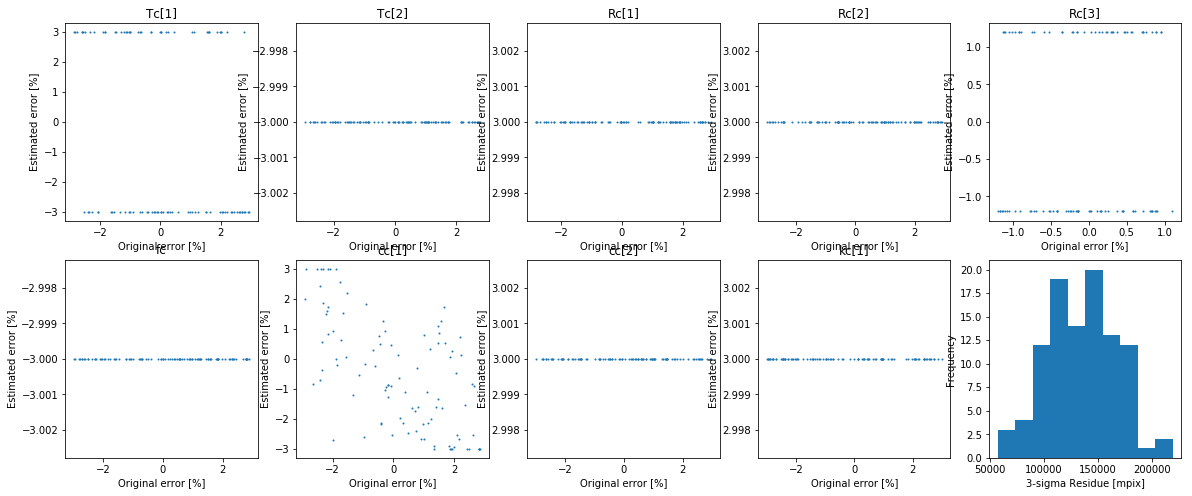

In [46]:
%matplotlib inline

# Get the fiducial choice for camera 1
prefix = "MANIFEST_sim_001_coord_data_camera-1"
params = GetFiducialParameter(prefix)
plateTarget = ReadPlatePos(prefix)
plateFiducial = MakePlateFiducial(100,params.DFOV*0.5,params.ROC)

pixFiducialFid = ConvertPlateToPix(plateFiducial,params)

WIDTH,HEIGHT = 2448,2050

plt.clf()
fig,axs = plt.subplots(2,5,figsize=(20,8))
axs = axs.flatten()

# Parameter variations that changes 13 parameters (2 for Tc[], 3 for Rc[], 1 for fc, 5 for kc[], 2 for cc[])
Nvar = 100
randVar = np.random.rand(Nvar,13)*6-3.
randVar[:,4] *= 0.4  # Rc[2] should be far less than 1.2%

arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO = randVar[:,0],randVar[:,1],randVar[:,2],randVar[:,3],randVar[:,4],randVar[:,5],randVar[:,11],randVar[:,12],randVar[:,6]
arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE = [],[],[],[],[],[],[],[],[]

errBudget = []
for rv,ivar in zip(randVar,range(1,Nvar+1)):
    newParams = ChangeFullFiducialParameter(params,rv)
    pixTarget = ConvertPlateToPix(plateTarget,newParams)
    pixFiducial = ConvertPlateToPix(plateFiducial,newParams)
        
    pixFiducialSub = CollectPixWithinFrame(pixFiducial,WIDTH,HEIGHT)
    plateFiducialSub = GetFiducialSubset(plateFiducial,pixFiducialFid,pixFiducialSub)
    
    estParams = RecalibrateParameter(plateFiducialSub,pixFiducialSub,params)
    arrTcAE.append(estParams.Tc[0]/params.Tc[1]*100)
    arrTcBE.append((estParams.Tc[1]-params.Tc[1])/params.Tc[1]*100)
    arrRcAE.append((estParams.Rc[0]-params.Rc[0])/params.Rc[0]*100)
    arrRcBE.append((estParams.Rc[1]-params.Rc[1])/params.Rc[1]*100)
    arrRcCE.append((estParams.Rc[2]-params.Rc[2])/params.Rc[2]*100)
    arrFcE.append((estParams.fc-params.fc)/params.fc*100)
    arrCcAE.append((estParams.cc[0]-params.cc[0])/params.cc[0]*100)
    arrCcBE.append((estParams.cc[1]-params.cc[1])/params.cc[1]*100)
    arrKcAE.append((estParams.kc[0]-params.kc[0])/params.kc[0]*100)

    estPixTarget = ConvertPlateToPix(plateTarget,estParams)
    residues = np.sqrt((estPixTarget[:,0]-pixTarget[:,0])**2 + (estPixTarget[:,1]-pixTarget[:,1])**2)*1E3
    
    errBudget.append(np.percentile(residues,99.865))


for ax,orig,est,valType in zip(axs[:-1],
                                [arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO],
                              [arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE],
                              ["Tc[1]","Tc[2]","Rc[1]","Rc[2]","Rc[3]","fc","cc[1]","cc[2]","kc[1]"]):
    ax.scatter(orig,est,s=1,rasterized=True)
    ax.set_title(valType)
    ax.set_xlabel("Original error [%]")
    ax.set_ylabel("Estimated error [%]")
    
axs[-1].hist(errBudget)
axs[-1].set_xlabel("3-sigma Residue [mpix]")
axs[-1].set_ylabel("Frequency")
plt.savefig("plateFiducialOnly_3p.pdf",bbox_inches="tight",dpi=150)

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


 ---> Trial 65 : parameter converged (or maximum trial reached)
 ---> Trial 100 : max. parameter error is 0.581389 percent
 ---> Trial 122 : parameter converged (or maximum trial reached)
 ---> Trial 67 : parameter converged (or maximum trial reached)
 ---> Trial 75 : parameter converged (or maximum trial reached)
 ---> Trial 94 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 89 : parameter converged (or maximum trial reached)
 ---> Trial 100 : max. parameter error is 1.491019 percent
 ---> Trial 119 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 71 : parameter converged (or maximum trial reached)
 ---> Trial 100 : parameter converged (or maximum trial reached)
 ---> Trial 100 : max. parameter error is 1.470295 percent
 ---> Trial 162 : parameter converged (or maximum trial

<Figure size 432x288 with 0 Axes>

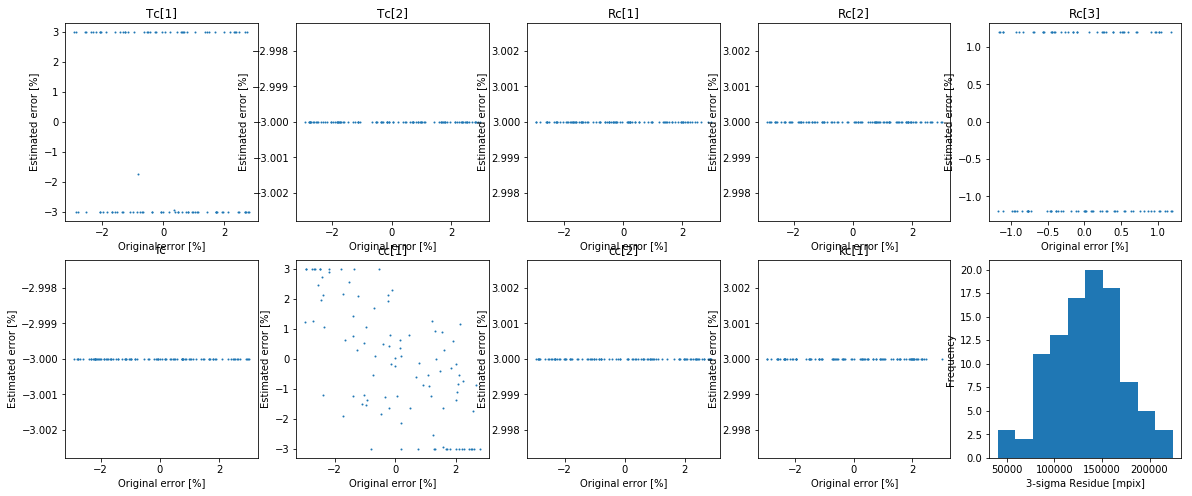

In [47]:
%matplotlib inline

# Get the fiducial choice for camera 1
prefix = "MANIFEST_sim_001_coord_data_camera-1"
params = GetFiducialParameter(prefix)
plateTarget = ReadPlatePos(prefix)
plateFiducial = MakePlateFiducial(100,params.DFOV*0.5,params.ROC)

pixFiducialFid = ConvertPlateToPix(plateFiducial,params)

WIDTH,HEIGHT = 2448,2050

plt.clf()
fig,axs = plt.subplots(2,5,figsize=(20,8))
axs = axs.flatten()

# Parameter variations that changes 13 parameters (2 for Tc[], 3 for Rc[], 1 for fc, 5 for kc[], 2 for cc[])
Nvar = 100
randVar = np.random.rand(Nvar,13)*6-3.
randVar[:,4] *= 0.4  # Rc[2] should be far less than 1.2%

arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO = randVar[:,0],randVar[:,1],randVar[:,2],randVar[:,3],randVar[:,4],randVar[:,5],randVar[:,11],randVar[:,12],randVar[:,6]
arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE = [],[],[],[],[],[],[],[],[]

errBudget = []
for rv,ivar in zip(randVar,range(1,Nvar+1)):
    newParams = ChangeFullFiducialParameter(params,rv)
    pixTarget = ConvertPlateToPix(plateTarget,newParams)
    pixFiducial = ConvertPlateToPix(plateFiducial,newParams)
        
    pixFiducialSub = CollectPixWithinFrame(pixFiducial,WIDTH,HEIGHT)
    plateFiducialSub = GetFiducialSubset(plateFiducial,pixFiducialFid,pixFiducialSub)
    
    estParams = RecalibrateParameterCamFirst(plateFiducialSub,pixFiducialSub,params)
    arrTcAE.append(estParams.Tc[0]/params.Tc[1]*100)
    arrTcBE.append((estParams.Tc[1]-params.Tc[1])/params.Tc[1]*100)
    arrRcAE.append((estParams.Rc[0]-params.Rc[0])/params.Rc[0]*100)
    arrRcBE.append((estParams.Rc[1]-params.Rc[1])/params.Rc[1]*100)
    arrRcCE.append((estParams.Rc[2]-params.Rc[2])/params.Rc[2]*100)
    arrFcE.append((estParams.fc-params.fc)/params.fc*100)
    arrCcAE.append((estParams.cc[0]-params.cc[0])/params.cc[0]*100)
    arrCcBE.append((estParams.cc[1]-params.cc[1])/params.cc[1]*100)
    arrKcAE.append((estParams.kc[0]-params.kc[0])/params.kc[0]*100)

    estPixTarget = ConvertPlateToPix(plateTarget,estParams)
    residues = np.sqrt((estPixTarget[:,0]-pixTarget[:,0])**2 + (estPixTarget[:,1]-pixTarget[:,1])**2)*1E3
    
    errBudget.append(np.percentile(residues,99.865))


for ax,orig,est,valType in zip(axs[:-1],
                                [arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO],
                              [arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE],
                              ["Tc[1]","Tc[2]","Rc[1]","Rc[2]","Rc[3]","fc","cc[1]","cc[2]","kc[1]"]):
    ax.scatter(orig,est,s=1,rasterized=True)
    ax.set_title(valType)
    ax.set_xlabel("Original error [%]")
    ax.set_ylabel("Estimated error [%]")
    
axs[-1].hist(errBudget)
axs[-1].set_xlabel("3-sigma Residue [mpix]")
axs[-1].set_ylabel("Frequency")
plt.savefig("plateFiducialOnly_3p_camFirst.pdf",bbox_inches="tight",dpi=150)

### (2) $\pm 1\%$

In [49]:
def RecalibrateParameter(arrPlate,arrPix,paramsFid):
    # Here, let's consider STAGGERED fitting of plate alignment parameters and camera calibration parameters
    # 1. Initialize two types of parameters by using fiducial choice
    plateParam = np.concatenate((paramsFid.Tc[:-1],paramsFid.Rc))
    camParam = np.concatenate((np.array([paramsFid.fc]),paramsFid.kc,paramsFid.cc))
    
    plateParamFid,camParamFid = np.copy(plateParam),np.copy(camParam)
    param = np.concatenate((plateParam,camParam))
    
    plateLowPercent,plateHighPercent = plateParamFid*0.99,plateParamFid*1.01
    camLowPercent,camHighPercent = camParamFid*0.99,camParamFid*1.01
    plateLowBound = np.minimum(plateLowPercent,plateHighPercent) + np.array([-np.abs(paramsFid.Tc[1])*0.01,0,0,0,np.abs(paramsFid.Rc[2]*0.006)])
    plateHighBound = np.maximum(plateLowPercent,plateHighPercent) + np.array([np.abs(paramsFid.Tc[1])*0.01,0,0,0,-np.abs(paramsFid.Rc[2]*0.006)])
    camLowBound = np.minimum(camLowPercent,camHighPercent) + np.array([0,0,-1e-6,-1e-6,-1e-6,-1e-6,0,0])
    camHighBound = np.maximum(camLowPercent,camHighPercent) + np.array([0,0,1e-6,1e-6,1e-6,1e-6,0,0])
    
    # 2. Fit until it converges to something....
    iTrial = 0
    while iTrial < 1000:
        plateParamOld,camParamOld,paramOld = np.copy(plateParam),np.copy(camParam),np.copy(param)
        plateParam = opt.least_squares(ResidueChangePlate,plateParamOld,
                                     args=(arrPlate,arrPix,camParamOld),
                                       bounds=(plateLowBound,plateHighBound),
                                      ftol=1E-16,xtol=1E-16).x
        camParam = opt.least_squares(ResidueChangeCam,camParamOld,
                                    args=(arrPlate,arrPix,plateParam),
                                    bounds=(camLowBound,camHighBound),
                                    ftol=1E-16,xtol=1E-16).x
        iTrial += 1
        param = np.concatenate((plateParam,camParam))
        
        if iTrial < 3:
            continue
        error = np.nanmax(np.abs(param-paramOld)/np.abs(paramOld))
        if error < 1E-6:
            break
        if iTrial % 100 == 0:
            print(" ---> Trial %d : max. parameter error is %f percent" % (iTrial,error*100.))
            
    print(" ---> Trial %d : parameter converged (or maximum trial reached)" % (iTrial))
            
    return ConstructParameter(plateParam,camParam)

def RecalibrateParameterCamFirst(arrPlate,arrPix,paramsFid):
    # Here, let's consider STAGGERED fitting of plate alignment parameters and camera calibration parameters
    # 1. Initialize two types of parameters by using fiducial choice
    plateParam = np.concatenate((paramsFid.Tc[:-1],paramsFid.Rc))
    camParam = np.concatenate((np.array([paramsFid.fc]),paramsFid.kc,paramsFid.cc))
    
    plateParamFid,camParamFid = np.copy(plateParam),np.copy(camParam)
    param = np.concatenate((plateParam,camParam))
    
    plateLowPercent,plateHighPercent = plateParamFid*0.99,plateParamFid*1.01
    camLowPercent,camHighPercent = camParamFid*0.99,camParamFid*1.01
    plateLowBound = np.minimum(plateLowPercent,plateHighPercent) + np.array([-np.abs(paramsFid.Tc[1])*0.01,0,0,0,np.abs(paramsFid.Rc[2])*0.006])
    plateHighBound = np.maximum(plateLowPercent,plateHighPercent) + np.array([np.abs(paramsFid.Tc[1])*0.01,0,0,0,-np.abs(paramsFid.Rc[2])*0.006])
    camLowBound = np.minimum(camLowPercent,camHighPercent) + np.array([0,0,-1e-6,-1e-6,-1e-6,-1e-6,0,0])
    camHighBound = np.maximum(camLowPercent,camHighPercent) + np.array([0,0,1e-6,1e-6,1e-6,1e-6,0,0])
    
    # 2. Fit until it converges to something....
    iTrial = 0
    while iTrial < 1000:
        plateParamOld,camParamOld,paramOld = np.copy(plateParam),np.copy(camParam),np.copy(param)
        camParam = opt.least_squares(ResidueChangeCam,camParamOld,
                                    args=(arrPlate,arrPix,plateParamOld),
                                    bounds=(camLowBound,camHighBound),
                                    ftol=1E-16,xtol=1E-16).x
        plateParam = opt.least_squares(ResidueChangePlate,plateParamOld,
                                     args=(arrPlate,arrPix,camParam),
                                       bounds=(plateLowBound,plateHighBound),
                                      ftol=1E-16,xtol=1E-16).x

        iTrial += 1
        param = np.concatenate((plateParam,camParam))
        
        if iTrial < 3:
            continue
        error = np.nanmax(np.abs(param-paramOld)/np.abs(paramOld))
        if error < 1E-6:
            break
        if iTrial % 100 == 0:
            print(" ---> Trial %d : max. parameter error is %f percent" % (iTrial,error*100.))
            
    print(" ---> Trial %d : parameter converged (or maximum trial reached)" % (iTrial))
            
    return ConstructParameter(plateParam,camParam)

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


 ---> Trial 40 : parameter converged (or maximum trial reached)
 ---> Trial 34 : parameter converged (or maximum trial reached)
 ---> Trial 30 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 100 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum tr

<Figure size 432x288 with 0 Axes>

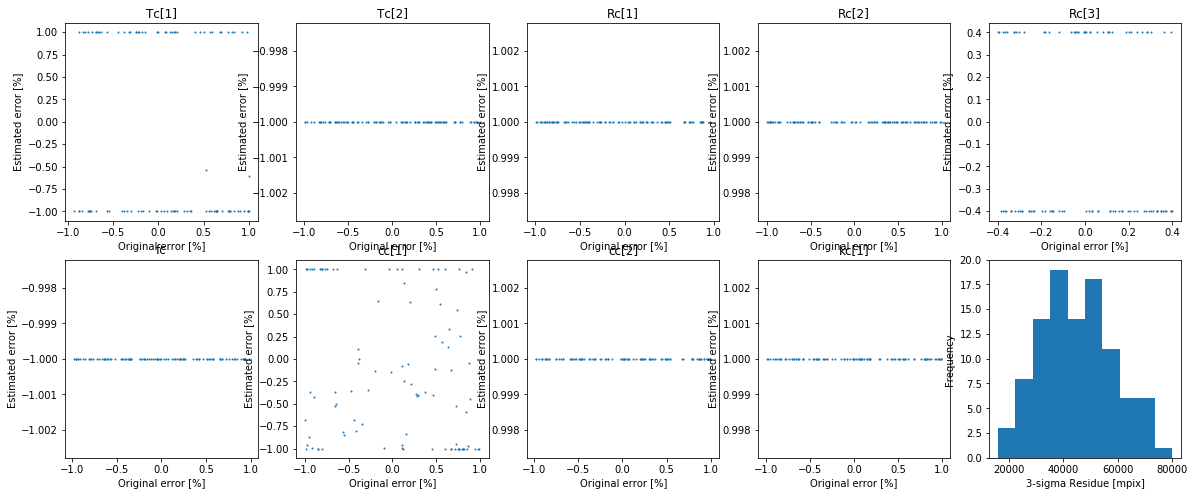

In [50]:
%matplotlib inline

# Get the fiducial choice for camera 1
prefix = "MANIFEST_sim_001_coord_data_camera-1"
params = GetFiducialParameter(prefix)
plateTarget = ReadPlatePos(prefix)
plateFiducial = MakePlateFiducial(100,params.DFOV*0.5,params.ROC)

pixFiducialFid = ConvertPlateToPix(plateFiducial,params)

WIDTH,HEIGHT = 2448,2050

plt.clf()
fig,axs = plt.subplots(2,5,figsize=(20,8))
axs = axs.flatten()

# Parameter variations that changes 13 parameters (2 for Tc[], 3 for Rc[], 1 for fc, 5 for kc[], 2 for cc[])
Nvar = 100
randVar = np.random.rand(Nvar,13)*2-1.
randVar[:,4] *= 0.4  # Rc[2] should be far less than 0.4%

arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO = randVar[:,0],randVar[:,1],randVar[:,2],randVar[:,3],randVar[:,4],randVar[:,5],randVar[:,11],randVar[:,12],randVar[:,6]
arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE = [],[],[],[],[],[],[],[],[]

errBudget = []
for rv,ivar in zip(randVar,range(1,Nvar+1)):
    newParams = ChangeFullFiducialParameter(params,rv)
    pixTarget = ConvertPlateToPix(plateTarget,newParams)
    pixFiducial = ConvertPlateToPix(plateFiducial,newParams)
        
    pixFiducialSub = CollectPixWithinFrame(pixFiducial,WIDTH,HEIGHT)
    plateFiducialSub = GetFiducialSubset(plateFiducial,pixFiducialFid,pixFiducialSub)
    
    estParams = RecalibrateParameter(plateFiducialSub,pixFiducialSub,params)
    arrTcAE.append(estParams.Tc[0]/params.Tc[1]*100)
    arrTcBE.append((estParams.Tc[1]-params.Tc[1])/params.Tc[1]*100)
    arrRcAE.append((estParams.Rc[0]-params.Rc[0])/params.Rc[0]*100)
    arrRcBE.append((estParams.Rc[1]-params.Rc[1])/params.Rc[1]*100)
    arrRcCE.append((estParams.Rc[2]-params.Rc[2])/params.Rc[2]*100)
    arrFcE.append((estParams.fc-params.fc)/params.fc*100)
    arrCcAE.append((estParams.cc[0]-params.cc[0])/params.cc[0]*100)
    arrCcBE.append((estParams.cc[1]-params.cc[1])/params.cc[1]*100)
    arrKcAE.append((estParams.kc[0]-params.kc[0])/params.kc[0]*100)

    estPixTarget = ConvertPlateToPix(plateTarget,estParams)
    residues = np.sqrt((estPixTarget[:,0]-pixTarget[:,0])**2 + (estPixTarget[:,1]-pixTarget[:,1])**2)*1E3
    
    errBudget.append(np.percentile(residues,99.865))


for ax,orig,est,valType in zip(axs[:-1],
                                [arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO],
                              [arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE],
                              ["Tc[1]","Tc[2]","Rc[1]","Rc[2]","Rc[3]","fc","cc[1]","cc[2]","kc[1]"]):
    ax.scatter(orig,est,s=1,rasterized=True)
    ax.set_title(valType)
    ax.set_xlabel("Original error [%]")
    ax.set_ylabel("Estimated error [%]")
    
axs[-1].hist(errBudget)
axs[-1].set_xlabel("3-sigma Residue [mpix]")
axs[-1].set_ylabel("Frequency")
plt.savefig("plateFiducialOnly_1p.pdf",bbox_inches="tight",dpi=150)

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 79 : parameter converged (or maximum trial reached)
 ---> Trial 58 : parameter converged (or maximum trial reached)
 ---> Trial 60 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 85 : parameter converged (or maximum trial reached)
 ---> Trial 61 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 100 : max. parameter error is 1.409246 percent
 ---> Trial 103 : parameter converged (or maximum trial reached)
 ---> Trial 100 : max. parameter error is 1.349438 percent
 ---> Trial 116 : parameter converged (or maximum trial reached)
 ---> Trial 47 : parameter converged (or maximum trial reached)
 ---> Trial 100 : max. parameter error is 0.001285 percent
 ---> Trial 101 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial r

<Figure size 432x288 with 0 Axes>

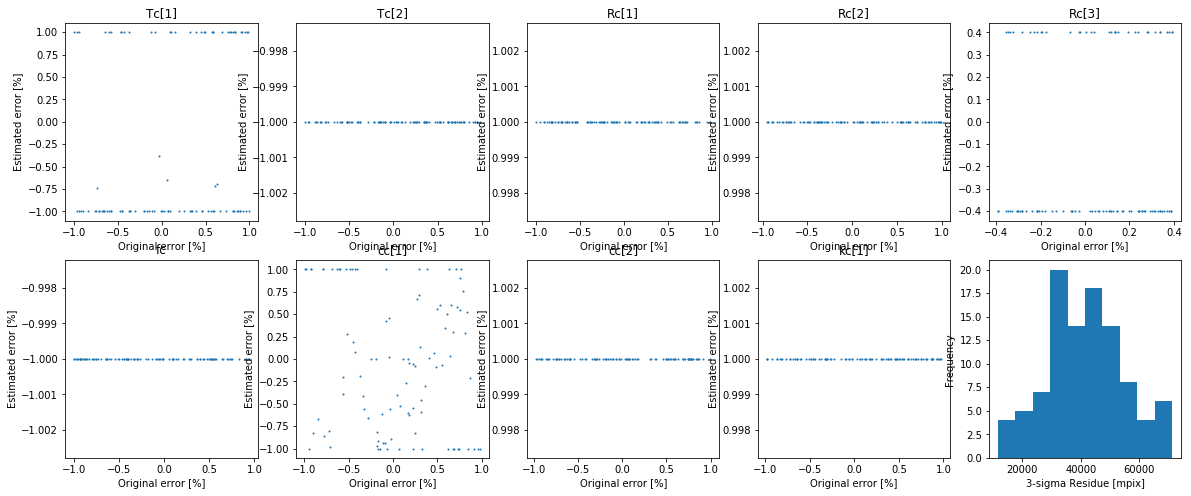

In [51]:
%matplotlib inline

# Get the fiducial choice for camera 1
prefix = "MANIFEST_sim_001_coord_data_camera-1"
params = GetFiducialParameter(prefix)
plateTarget = ReadPlatePos(prefix)
plateFiducial = MakePlateFiducial(100,params.DFOV*0.5,params.ROC)

pixFiducialFid = ConvertPlateToPix(plateFiducial,params)

WIDTH,HEIGHT = 2448,2050

plt.clf()
fig,axs = plt.subplots(2,5,figsize=(20,8))
axs = axs.flatten()

# Parameter variations that changes 13 parameters (2 for Tc[], 3 for Rc[], 1 for fc, 5 for kc[], 2 for cc[])
Nvar = 100
randVar = np.random.rand(Nvar,13)*2-1.
randVar[:,4] *= 0.4  # Rc[2] should be far less than 0.4%

arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO = randVar[:,0],randVar[:,1],randVar[:,2],randVar[:,3],randVar[:,4],randVar[:,5],randVar[:,11],randVar[:,12],randVar[:,6]
arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE = [],[],[],[],[],[],[],[],[]

errBudget = []
for rv,ivar in zip(randVar,range(1,Nvar+1)):
    newParams = ChangeFullFiducialParameter(params,rv)
    pixTarget = ConvertPlateToPix(plateTarget,newParams)
    pixFiducial = ConvertPlateToPix(plateFiducial,newParams)
        
    pixFiducialSub = CollectPixWithinFrame(pixFiducial,WIDTH,HEIGHT)
    plateFiducialSub = GetFiducialSubset(plateFiducial,pixFiducialFid,pixFiducialSub)
    
    estParams = RecalibrateParameterCamFirst(plateFiducialSub,pixFiducialSub,params)
    arrTcAE.append(estParams.Tc[0]/params.Tc[1]*100)
    arrTcBE.append((estParams.Tc[1]-params.Tc[1])/params.Tc[1]*100)
    arrRcAE.append((estParams.Rc[0]-params.Rc[0])/params.Rc[0]*100)
    arrRcBE.append((estParams.Rc[1]-params.Rc[1])/params.Rc[1]*100)
    arrRcCE.append((estParams.Rc[2]-params.Rc[2])/params.Rc[2]*100)
    arrFcE.append((estParams.fc-params.fc)/params.fc*100)
    arrCcAE.append((estParams.cc[0]-params.cc[0])/params.cc[0]*100)
    arrCcBE.append((estParams.cc[1]-params.cc[1])/params.cc[1]*100)
    arrKcAE.append((estParams.kc[0]-params.kc[0])/params.kc[0]*100)

    estPixTarget = ConvertPlateToPix(plateTarget,estParams)
    residues = np.sqrt((estPixTarget[:,0]-pixTarget[:,0])**2 + (estPixTarget[:,1]-pixTarget[:,1])**2)*1E3
    
    errBudget.append(np.percentile(residues,99.865))


for ax,orig,est,valType in zip(axs[:-1],
                                [arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO],
                              [arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE],
                              ["Tc[1]","Tc[2]","Rc[1]","Rc[2]","Rc[3]","fc","cc[1]","cc[2]","kc[1]"]):
    ax.scatter(orig,est,s=1,rasterized=True)
    ax.set_title(valType)
    ax.set_xlabel("Original error [%]")
    ax.set_ylabel("Estimated error [%]")
    
axs[-1].hist(errBudget)
axs[-1].set_xlabel("3-sigma Residue [mpix]")
axs[-1].set_ylabel("Frequency")
plt.savefig("plateFiducialOnly_1p_camFirst.pdf",bbox_inches="tight",dpi=150)

So this means that the current fitting method (**staggered**) for the plate fiducials only cannot achieve the requirement, even if the allowed parameter error range is very small ($\pm 1\%$).

The figures show that nearly all parameters (except cc[1]?) failed finding its original values and stay the boundary.
This may mean that iteration of least square fitting for the parameter convergence is harmful for finding the good parameters, if the parameter covergence just push the parameters the boundaries.
How about changing it into a single run?

## 4. Single-run of staggered fit

In [52]:
def RecalibrateParameter(arrPlate,arrPix,paramsFid):
    # Here, let's consider STAGGERED fitting of plate alignment parameters and camera calibration parameters
    # 1. Initialize two types of parameters by using fiducial choice
    plateParam = np.concatenate((paramsFid.Tc[:-1],paramsFid.Rc))
    camParam = np.concatenate((np.array([paramsFid.fc]),paramsFid.kc,paramsFid.cc))
    
    plateParamFid,camParamFid = np.copy(plateParam),np.copy(camParam)
    param = np.concatenate((plateParam,camParam))
    
    plateLowPercent,plateHighPercent = plateParamFid*0.99,plateParamFid*1.01
    camLowPercent,camHighPercent = camParamFid*0.99,camParamFid*1.01
    plateLowBound = np.minimum(plateLowPercent,plateHighPercent) + np.array([-np.abs(paramsFid.Tc[1])*0.01,0,0,0,np.abs(paramsFid.Rc[2]*0.006)])
    plateHighBound = np.maximum(plateLowPercent,plateHighPercent) + np.array([np.abs(paramsFid.Tc[1])*0.01,0,0,0,-np.abs(paramsFid.Rc[2]*0.006)])
    camLowBound = np.minimum(camLowPercent,camHighPercent) + np.array([0,0,-1e-6,-1e-6,-1e-6,-1e-6,0,0])
    camHighBound = np.maximum(camLowPercent,camHighPercent) + np.array([0,0,1e-6,1e-6,1e-6,1e-6,0,0])
    
    # 2. Fit once
    plateParam = opt.least_squares(ResidueChangePlate,plateParam,
                                     args=(arrPlate,arrPix,camParam),
                                       bounds=(plateLowBound,plateHighBound),
                                      ftol=1E-16,xtol=1E-16).x
    camParam = opt.least_squares(ResidueChangeCam,camParam,
                                    args=(arrPlate,arrPix,plateParam),
                                    bounds=(camLowBound,camHighBound),
                                    ftol=1E-16,xtol=1E-16).x
            
    return ConstructParameter(plateParam,camParam)

def RecalibrateParameterCamFirst(arrPlate,arrPix,paramsFid):
    # Here, let's consider STAGGERED fitting of plate alignment parameters and camera calibration parameters
    # 1. Initialize two types of parameters by using fiducial choice
    plateParam = np.concatenate((paramsFid.Tc[:-1],paramsFid.Rc))
    camParam = np.concatenate((np.array([paramsFid.fc]),paramsFid.kc,paramsFid.cc))
    
    plateParamFid,camParamFid = np.copy(plateParam),np.copy(camParam)
    param = np.concatenate((plateParam,camParam))
    
    plateLowPercent,plateHighPercent = plateParamFid*0.99,plateParamFid*1.01
    camLowPercent,camHighPercent = camParamFid*0.99,camParamFid*1.01
    plateLowBound = np.minimum(plateLowPercent,plateHighPercent) + np.array([-np.abs(paramsFid.Tc[1])*0.01,0,0,0,np.abs(paramsFid.Rc[2])*0.006])
    plateHighBound = np.maximum(plateLowPercent,plateHighPercent) + np.array([np.abs(paramsFid.Tc[1])*0.01,0,0,0,-np.abs(paramsFid.Rc[2])*0.006])
    camLowBound = np.minimum(camLowPercent,camHighPercent) + np.array([0,0,-1e-6,-1e-6,-1e-6,-1e-6,0,0])
    camHighBound = np.maximum(camLowPercent,camHighPercent) + np.array([0,0,1e-6,1e-6,1e-6,1e-6,0,0])
    
    # 2. Fit once
    camParam = opt.least_squares(ResidueChangeCam,camParam,
                                    args=(arrPlate,arrPix,plateParam),
                                    bounds=(camLowBound,camHighBound),
                                    ftol=1E-16,xtol=1E-16).x
    plateParam = opt.least_squares(ResidueChangePlate,plateParam,
                                     args=(arrPlate,arrPix,camParam),
                                       bounds=(plateLowBound,plateHighBound),
                                      ftol=1E-16,xtol=1E-16).x
            
    return ConstructParameter(plateParam,camParam)

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


<Figure size 432x288 with 0 Axes>

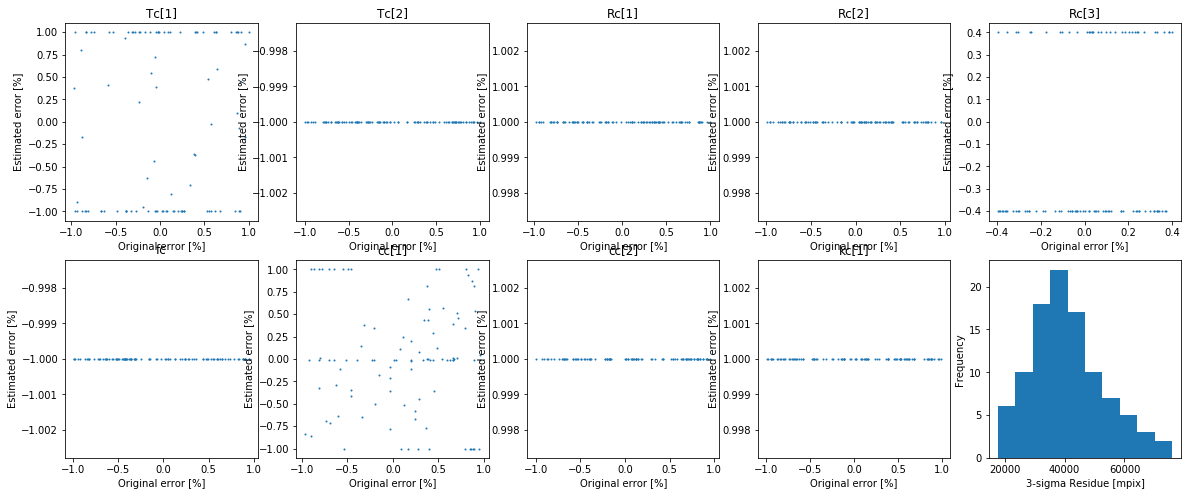

In [53]:
%matplotlib inline

# Get the fiducial choice for camera 1
prefix = "MANIFEST_sim_001_coord_data_camera-1"
params = GetFiducialParameter(prefix)
plateTarget = ReadPlatePos(prefix)
plateFiducial = MakePlateFiducial(100,params.DFOV*0.5,params.ROC)

pixFiducialFid = ConvertPlateToPix(plateFiducial,params)

WIDTH,HEIGHT = 2448,2050

plt.clf()
fig,axs = plt.subplots(2,5,figsize=(20,8))
axs = axs.flatten()

# Parameter variations that changes 13 parameters (2 for Tc[], 3 for Rc[], 1 for fc, 5 for kc[], 2 for cc[])
Nvar = 100
randVar = np.random.rand(Nvar,13)*2-1.
randVar[:,4] *= 0.4  # Rc[2] should be far less than 0.4%

arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO = randVar[:,0],randVar[:,1],randVar[:,2],randVar[:,3],randVar[:,4],randVar[:,5],randVar[:,11],randVar[:,12],randVar[:,6]
arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE = [],[],[],[],[],[],[],[],[]

errBudget = []
for rv,ivar in zip(randVar,range(1,Nvar+1)):
    newParams = ChangeFullFiducialParameter(params,rv)
    pixTarget = ConvertPlateToPix(plateTarget,newParams)
    pixFiducial = ConvertPlateToPix(plateFiducial,newParams)
        
    pixFiducialSub = CollectPixWithinFrame(pixFiducial,WIDTH,HEIGHT)
    plateFiducialSub = GetFiducialSubset(plateFiducial,pixFiducialFid,pixFiducialSub)
    
    estParams = RecalibrateParameter(plateFiducialSub,pixFiducialSub,params)
    arrTcAE.append(estParams.Tc[0]/params.Tc[1]*100)
    arrTcBE.append((estParams.Tc[1]-params.Tc[1])/params.Tc[1]*100)
    arrRcAE.append((estParams.Rc[0]-params.Rc[0])/params.Rc[0]*100)
    arrRcBE.append((estParams.Rc[1]-params.Rc[1])/params.Rc[1]*100)
    arrRcCE.append((estParams.Rc[2]-params.Rc[2])/params.Rc[2]*100)
    arrFcE.append((estParams.fc-params.fc)/params.fc*100)
    arrCcAE.append((estParams.cc[0]-params.cc[0])/params.cc[0]*100)
    arrCcBE.append((estParams.cc[1]-params.cc[1])/params.cc[1]*100)
    arrKcAE.append((estParams.kc[0]-params.kc[0])/params.kc[0]*100)

    estPixTarget = ConvertPlateToPix(plateTarget,estParams)
    residues = np.sqrt((estPixTarget[:,0]-pixTarget[:,0])**2 + (estPixTarget[:,1]-pixTarget[:,1])**2)*1E3
    
    errBudget.append(np.percentile(residues,99.865))


for ax,orig,est,valType in zip(axs[:-1],
                                [arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO],
                              [arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE],
                              ["Tc[1]","Tc[2]","Rc[1]","Rc[2]","Rc[3]","fc","cc[1]","cc[2]","kc[1]"]):
    ax.scatter(orig,est,s=1,rasterized=True)
    ax.set_title(valType)
    ax.set_xlabel("Original error [%]")
    ax.set_ylabel("Estimated error [%]")
    
axs[-1].hist(errBudget)
axs[-1].set_xlabel("3-sigma Residue [mpix]")
axs[-1].set_ylabel("Frequency")
plt.savefig("plateFiducialOnly_1p_noIter.pdf",bbox_inches="tight",dpi=150)

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


<Figure size 432x288 with 0 Axes>

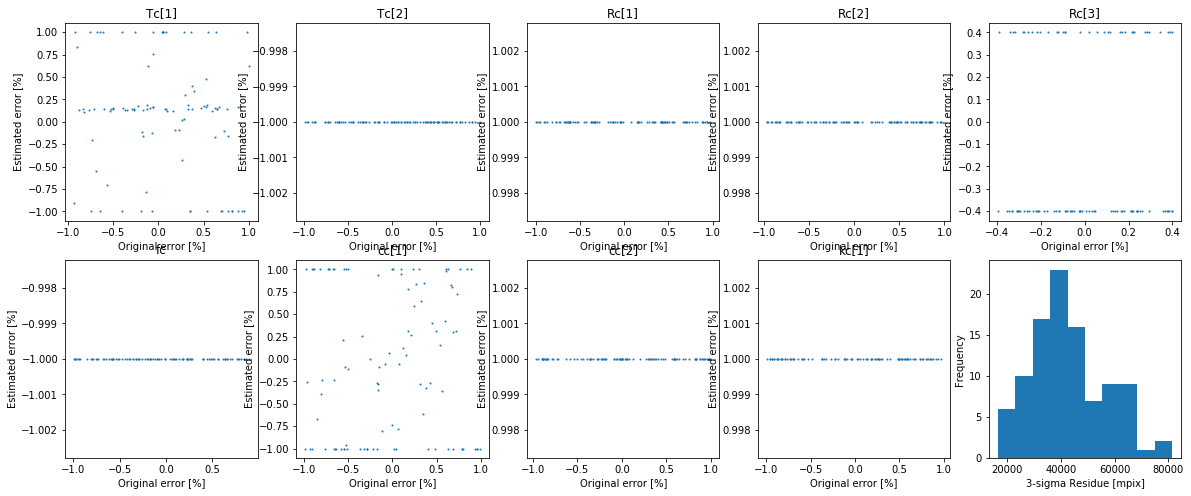

In [54]:
%matplotlib inline

# Get the fiducial choice for camera 1
prefix = "MANIFEST_sim_001_coord_data_camera-1"
params = GetFiducialParameter(prefix)
plateTarget = ReadPlatePos(prefix)
plateFiducial = MakePlateFiducial(100,params.DFOV*0.5,params.ROC)

pixFiducialFid = ConvertPlateToPix(plateFiducial,params)

WIDTH,HEIGHT = 2448,2050

plt.clf()
fig,axs = plt.subplots(2,5,figsize=(20,8))
axs = axs.flatten()

# Parameter variations that changes 13 parameters (2 for Tc[], 3 for Rc[], 1 for fc, 5 for kc[], 2 for cc[])
Nvar = 100
randVar = np.random.rand(Nvar,13)*2-1.
randVar[:,4] *= 0.4  # Rc[2] should be far less than 0.4%

arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO = randVar[:,0],randVar[:,1],randVar[:,2],randVar[:,3],randVar[:,4],randVar[:,5],randVar[:,11],randVar[:,12],randVar[:,6]
arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE = [],[],[],[],[],[],[],[],[]

errBudget = []
for rv,ivar in zip(randVar,range(1,Nvar+1)):
    newParams = ChangeFullFiducialParameter(params,rv)
    pixTarget = ConvertPlateToPix(plateTarget,newParams)
    pixFiducial = ConvertPlateToPix(plateFiducial,newParams)
        
    pixFiducialSub = CollectPixWithinFrame(pixFiducial,WIDTH,HEIGHT)
    plateFiducialSub = GetFiducialSubset(plateFiducial,pixFiducialFid,pixFiducialSub)
    
    estParams = RecalibrateParameterCamFirst(plateFiducialSub,pixFiducialSub,params)
    arrTcAE.append(estParams.Tc[0]/params.Tc[1]*100)
    arrTcBE.append((estParams.Tc[1]-params.Tc[1])/params.Tc[1]*100)
    arrRcAE.append((estParams.Rc[0]-params.Rc[0])/params.Rc[0]*100)
    arrRcBE.append((estParams.Rc[1]-params.Rc[1])/params.Rc[1]*100)
    arrRcCE.append((estParams.Rc[2]-params.Rc[2])/params.Rc[2]*100)
    arrFcE.append((estParams.fc-params.fc)/params.fc*100)
    arrCcAE.append((estParams.cc[0]-params.cc[0])/params.cc[0]*100)
    arrCcBE.append((estParams.cc[1]-params.cc[1])/params.cc[1]*100)
    arrKcAE.append((estParams.kc[0]-params.kc[0])/params.kc[0]*100)

    estPixTarget = ConvertPlateToPix(plateTarget,estParams)
    residues = np.sqrt((estPixTarget[:,0]-pixTarget[:,0])**2 + (estPixTarget[:,1]-pixTarget[:,1])**2)*1E3
    
    errBudget.append(np.percentile(residues,99.865))


for ax,orig,est,valType in zip(axs[:-1],
                                [arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO],
                              [arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE],
                              ["Tc[1]","Tc[2]","Rc[1]","Rc[2]","Rc[3]","fc","cc[1]","cc[2]","kc[1]"]):
    ax.scatter(orig,est,s=1,rasterized=True)
    ax.set_title(valType)
    ax.set_xlabel("Original error [%]")
    ax.set_ylabel("Estimated error [%]")
    
axs[-1].hist(errBudget)
axs[-1].set_xlabel("3-sigma Residue [mpix]")
axs[-1].set_ylabel("Frequency")
plt.savefig("plateFiducialOnly_1p_camFirst_noIter.pdf",bbox_inches="tight",dpi=150)

Some lessons:
- Iterations of staggered fits does not enhance the result much, at least for this case.
- However, most of the parametes already go to the boundaries even at the first round. This means that, if all parameters are allowed to vary, staggered fit with only plate fiducials **cannot** find any good result.

Therefore, there are basically two ways to consider:
- We may need **more standards** other than plate fiducials to fit the data. Guide bundles around the plate will be the best options that we can use. However, I am not sure how to use metrology fibers yet.
- We may need **other fitting method** than staggered fit. For example, if the fiducial parameters are known, one can use machine learning by training many sets of (pixel positions of plate fiducials) - (parameters).

## 5. Adding guide bundles

### (1) $N = 30$

In [55]:
def MakeGuideBundle(N,radius,ROC):
    arrRand = np.random.rand(N,2)
    arrR,arrTheta = radius*np.sqrt(arrRand[:,0]),2.*np.pi*arrRand[:,1]
    arrX,arrY = radius*np.cos(arrTheta),radius*np.sin(arrTheta)
    arrZ = np.sqrt(ROC**2-arrX**2-arrY**2) - ROC
    
    return np.vstack([arrX,arrY,arrZ]).T

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


<Figure size 432x288 with 0 Axes>

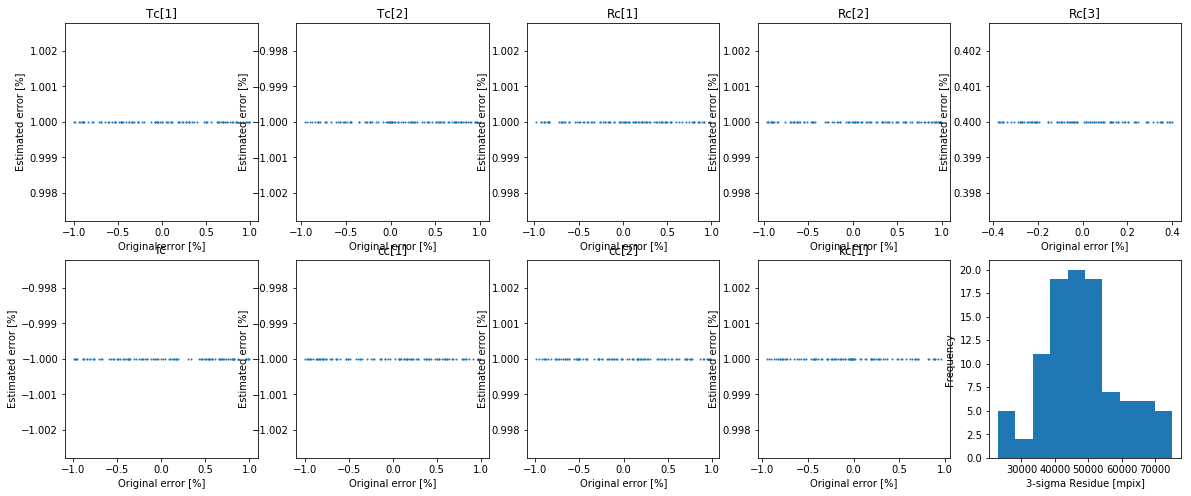

In [56]:
%matplotlib inline

# Get the fiducial choice for camera 1
prefix = "MANIFEST_sim_001_coord_data_camera-1"
params = GetFiducialParameter(prefix)
plateTarget = ReadPlatePos(prefix)

plateFiducial = MakePlateFiducial(100,params.DFOV*0.5,params.ROC)
pixFiducialFid = ConvertPlateToPix(plateFiducial,params)

plateGB = MakeGuideBundle(30,params.DFOV*0.5,params.ROC)
pixGBFid = ConvertPlateToPix(plateGB,params)

WIDTH,HEIGHT = 2448,2050

plt.clf()
fig,axs = plt.subplots(2,5,figsize=(20,8))
axs = axs.flatten()

# Parameter variations that changes 13 parameters (2 for Tc[], 3 for Rc[], 1 for fc, 5 for kc[], 2 for cc[])
Nvar = 100
randVar = np.random.rand(Nvar,13)*2-1.
randVar[:,4] *= 0.4  # Rc[2] should be far less than 0.4%

arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO = randVar[:,0],randVar[:,1],randVar[:,2],randVar[:,3],randVar[:,4],randVar[:,5],randVar[:,11],randVar[:,12],randVar[:,6]
arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE = [],[],[],[],[],[],[],[],[]

errBudget = []
for rv,ivar in zip(randVar,range(1,Nvar+1)):
    newParams = ChangeFullFiducialParameter(params,rv)
    pixTarget = ConvertPlateToPix(plateTarget,newParams)
    pixFiducial = ConvertPlateToPix(plateFiducial,newParams)
    pixGB = ConvertPlateToPix(plateGB,newParams)
        
    pixFiducialSub = CollectPixWithinFrame(pixFiducial,WIDTH,HEIGHT)
    plateFiducialSub = GetFiducialSubset(plateFiducial,pixFiducialFid,pixFiducialSub)
    
    pixGBSub = CollectPixWithinFrame(pixGB,WIDTH,HEIGHT)
    plateGBSub = GetFiducialSubset(plateGB,pixGBFid,pixGBSub)
    
    plateSub = np.concatenate((plateFiducialSub,plateGBSub))
    pixSub = np.concatenate((pixFiducialSub,pixGBSub))
    
    estParams = RecalibrateParameter(plateSub,pixSub,params)
    arrTcAE.append(estParams.Tc[0]/params.Tc[1]*100)
    arrTcBE.append((estParams.Tc[1]-params.Tc[1])/params.Tc[1]*100)
    arrRcAE.append((estParams.Rc[0]-params.Rc[0])/params.Rc[0]*100)
    arrRcBE.append((estParams.Rc[1]-params.Rc[1])/params.Rc[1]*100)
    arrRcCE.append((estParams.Rc[2]-params.Rc[2])/params.Rc[2]*100)
    arrFcE.append((estParams.fc-params.fc)/params.fc*100)
    arrCcAE.append((estParams.cc[0]-params.cc[0])/params.cc[0]*100)
    arrCcBE.append((estParams.cc[1]-params.cc[1])/params.cc[1]*100)
    arrKcAE.append((estParams.kc[0]-params.kc[0])/params.kc[0]*100)

    estPixTarget = ConvertPlateToPix(plateTarget,estParams)
    residues = np.sqrt((estPixTarget[:,0]-pixTarget[:,0])**2 + (estPixTarget[:,1]-pixTarget[:,1])**2)*1E3
    
    errBudget.append(np.percentile(residues,99.865))


for ax,orig,est,valType in zip(axs[:-1],
                                [arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO],
                              [arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE],
                              ["Tc[1]","Tc[2]","Rc[1]","Rc[2]","Rc[3]","fc","cc[1]","cc[2]","kc[1]"]):
    ax.scatter(orig,est,s=1,rasterized=True)
    ax.set_title(valType)
    ax.set_xlabel("Original error [%]")
    ax.set_ylabel("Estimated error [%]")
    
axs[-1].hist(errBudget)
axs[-1].set_xlabel("3-sigma Residue [mpix]")
axs[-1].set_ylabel("Frequency")
plt.savefig("plateFiducialOnly_1p_noIter_30bundle.pdf",bbox_inches="tight",dpi=150)

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


<Figure size 432x288 with 0 Axes>

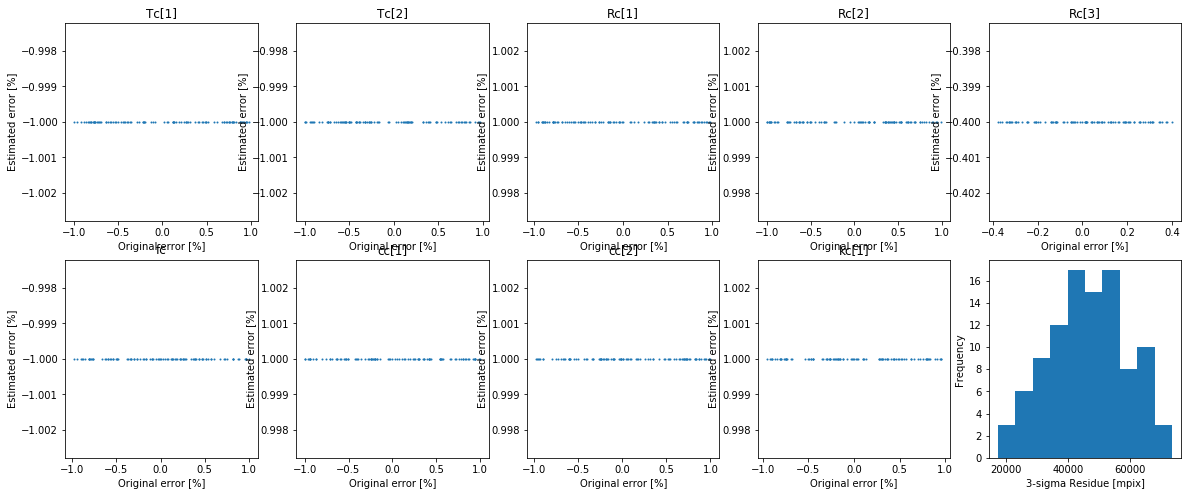

In [57]:
%matplotlib inline

# Get the fiducial choice for camera 1
prefix = "MANIFEST_sim_001_coord_data_camera-1"
params = GetFiducialParameter(prefix)
plateTarget = ReadPlatePos(prefix)

plateFiducial = MakePlateFiducial(100,params.DFOV*0.5,params.ROC)
pixFiducialFid = ConvertPlateToPix(plateFiducial,params)

plateGB = MakeGuideBundle(30,params.DFOV*0.5,params.ROC)
pixGBFid = ConvertPlateToPix(plateGB,params)

WIDTH,HEIGHT = 2448,2050

plt.clf()
fig,axs = plt.subplots(2,5,figsize=(20,8))
axs = axs.flatten()

# Parameter variations that changes 13 parameters (2 for Tc[], 3 for Rc[], 1 for fc, 5 for kc[], 2 for cc[])
Nvar = 100
randVar = np.random.rand(Nvar,13)*2-1.
randVar[:,4] *= 0.4  # Rc[2] should be far less than 0.4%

arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO = randVar[:,0],randVar[:,1],randVar[:,2],randVar[:,3],randVar[:,4],randVar[:,5],randVar[:,11],randVar[:,12],randVar[:,6]
arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE = [],[],[],[],[],[],[],[],[]

errBudget = []
for rv,ivar in zip(randVar,range(1,Nvar+1)):
    newParams = ChangeFullFiducialParameter(params,rv)
    pixTarget = ConvertPlateToPix(plateTarget,newParams)
    pixFiducial = ConvertPlateToPix(plateFiducial,newParams)
    pixGB = ConvertPlateToPix(plateGB,newParams)
        
    pixFiducialSub = CollectPixWithinFrame(pixFiducial,WIDTH,HEIGHT)
    plateFiducialSub = GetFiducialSubset(plateFiducial,pixFiducialFid,pixFiducialSub)
    
    pixGBSub = CollectPixWithinFrame(pixGB,WIDTH,HEIGHT)
    plateGBSub = GetFiducialSubset(plateGB,pixGBFid,pixGBSub)
    
    plateSub = np.concatenate((plateFiducialSub,plateGBSub))
    pixSub = np.concatenate((pixFiducialSub,pixGBSub))
    
    estParams = RecalibrateParameterCamFirst(plateSub,pixSub,params)
    arrTcAE.append(estParams.Tc[0]/params.Tc[1]*100)
    arrTcBE.append((estParams.Tc[1]-params.Tc[1])/params.Tc[1]*100)
    arrRcAE.append((estParams.Rc[0]-params.Rc[0])/params.Rc[0]*100)
    arrRcBE.append((estParams.Rc[1]-params.Rc[1])/params.Rc[1]*100)
    arrRcCE.append((estParams.Rc[2]-params.Rc[2])/params.Rc[2]*100)
    arrFcE.append((estParams.fc-params.fc)/params.fc*100)
    arrCcAE.append((estParams.cc[0]-params.cc[0])/params.cc[0]*100)
    arrCcBE.append((estParams.cc[1]-params.cc[1])/params.cc[1]*100)
    arrKcAE.append((estParams.kc[0]-params.kc[0])/params.kc[0]*100)

    estPixTarget = ConvertPlateToPix(plateTarget,estParams)
    residues = np.sqrt((estPixTarget[:,0]-pixTarget[:,0])**2 + (estPixTarget[:,1]-pixTarget[:,1])**2)*1E3
    
    errBudget.append(np.percentile(residues,99.865))


for ax,orig,est,valType in zip(axs[:-1],
                                [arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO],
                              [arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE],
                              ["Tc[1]","Tc[2]","Rc[1]","Rc[2]","Rc[3]","fc","cc[1]","cc[2]","kc[1]"]):
    ax.scatter(orig,est,s=1,rasterized=True)
    ax.set_title(valType)
    ax.set_xlabel("Original error [%]")
    ax.set_ylabel("Estimated error [%]")
    
axs[-1].hist(errBudget)
axs[-1].set_xlabel("3-sigma Residue [mpix]")
axs[-1].set_ylabel("Frequency")
plt.savefig("plateFiducialOnly_1p_camFirst_noIter_30bundle.pdf",bbox_inches="tight",dpi=150)

### (2) $N = 100$

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


<Figure size 432x288 with 0 Axes>

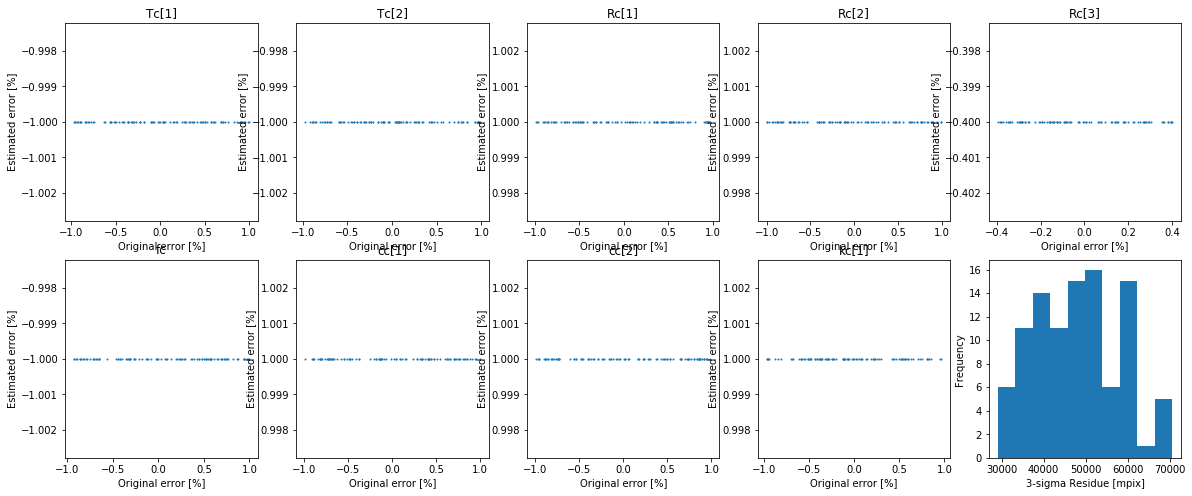

In [58]:
%matplotlib inline

# Get the fiducial choice for camera 1
prefix = "MANIFEST_sim_001_coord_data_camera-1"
params = GetFiducialParameter(prefix)
plateTarget = ReadPlatePos(prefix)

plateFiducial = MakePlateFiducial(100,params.DFOV*0.5,params.ROC)
pixFiducialFid = ConvertPlateToPix(plateFiducial,params)

plateGB = MakeGuideBundle(100,params.DFOV*0.5,params.ROC)
pixGBFid = ConvertPlateToPix(plateGB,params)

WIDTH,HEIGHT = 2448,2050

plt.clf()
fig,axs = plt.subplots(2,5,figsize=(20,8))
axs = axs.flatten()

# Parameter variations that changes 13 parameters (2 for Tc[], 3 for Rc[], 1 for fc, 5 for kc[], 2 for cc[])
Nvar = 100
randVar = np.random.rand(Nvar,13)*2-1.
randVar[:,4] *= 0.4  # Rc[2] should be far less than 0.4%

arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO = randVar[:,0],randVar[:,1],randVar[:,2],randVar[:,3],randVar[:,4],randVar[:,5],randVar[:,11],randVar[:,12],randVar[:,6]
arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE = [],[],[],[],[],[],[],[],[]

errBudget = []
for rv,ivar in zip(randVar,range(1,Nvar+1)):
    newParams = ChangeFullFiducialParameter(params,rv)
    pixTarget = ConvertPlateToPix(plateTarget,newParams)
    pixFiducial = ConvertPlateToPix(plateFiducial,newParams)
    pixGB = ConvertPlateToPix(plateGB,newParams)
        
    pixFiducialSub = CollectPixWithinFrame(pixFiducial,WIDTH,HEIGHT)
    plateFiducialSub = GetFiducialSubset(plateFiducial,pixFiducialFid,pixFiducialSub)
    
    pixGBSub = CollectPixWithinFrame(pixGB,WIDTH,HEIGHT)
    plateGBSub = GetFiducialSubset(plateGB,pixGBFid,pixGBSub)
    
    plateSub = np.concatenate((plateFiducialSub,plateGBSub))
    pixSub = np.concatenate((pixFiducialSub,pixGBSub))
    
    estParams = RecalibrateParameter(plateSub,pixSub,params)
    arrTcAE.append(estParams.Tc[0]/params.Tc[1]*100)
    arrTcBE.append((estParams.Tc[1]-params.Tc[1])/params.Tc[1]*100)
    arrRcAE.append((estParams.Rc[0]-params.Rc[0])/params.Rc[0]*100)
    arrRcBE.append((estParams.Rc[1]-params.Rc[1])/params.Rc[1]*100)
    arrRcCE.append((estParams.Rc[2]-params.Rc[2])/params.Rc[2]*100)
    arrFcE.append((estParams.fc-params.fc)/params.fc*100)
    arrCcAE.append((estParams.cc[0]-params.cc[0])/params.cc[0]*100)
    arrCcBE.append((estParams.cc[1]-params.cc[1])/params.cc[1]*100)
    arrKcAE.append((estParams.kc[0]-params.kc[0])/params.kc[0]*100)

    estPixTarget = ConvertPlateToPix(plateTarget,estParams)
    residues = np.sqrt((estPixTarget[:,0]-pixTarget[:,0])**2 + (estPixTarget[:,1]-pixTarget[:,1])**2)*1E3
    
    errBudget.append(np.percentile(residues,99.865))


for ax,orig,est,valType in zip(axs[:-1],
                                [arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO],
                              [arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE],
                              ["Tc[1]","Tc[2]","Rc[1]","Rc[2]","Rc[3]","fc","cc[1]","cc[2]","kc[1]"]):
    ax.scatter(orig,est,s=1,rasterized=True)
    ax.set_title(valType)
    ax.set_xlabel("Original error [%]")
    ax.set_ylabel("Estimated error [%]")
    
axs[-1].hist(errBudget)
axs[-1].set_xlabel("3-sigma Residue [mpix]")
axs[-1].set_ylabel("Frequency")
plt.savefig("plateFiducialOnly_1p_noIter_100bundle.pdf",bbox_inches="tight",dpi=150)

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


<Figure size 432x288 with 0 Axes>

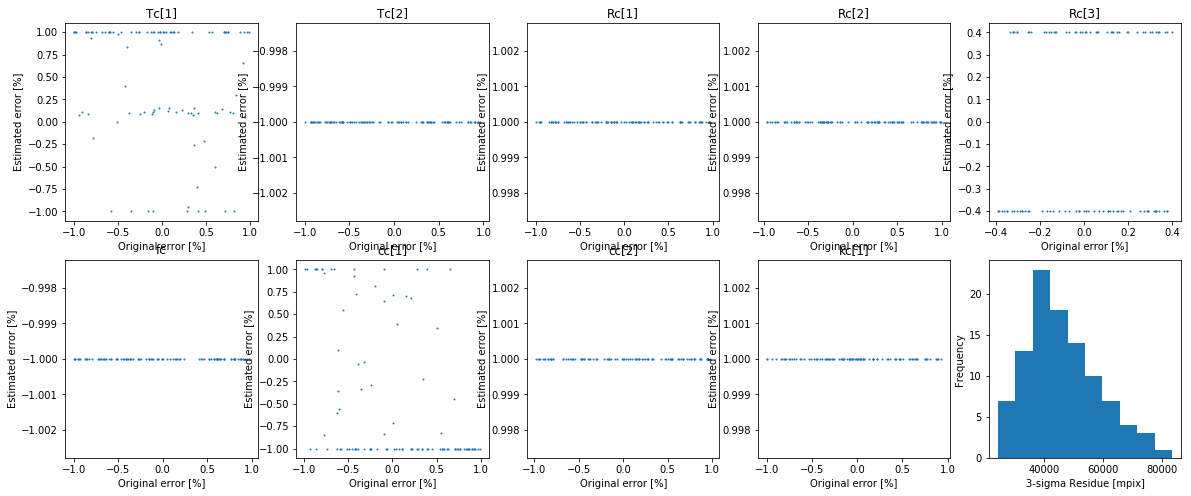

In [59]:
%matplotlib inline

# Get the fiducial choice for camera 1
prefix = "MANIFEST_sim_001_coord_data_camera-1"
params = GetFiducialParameter(prefix)
plateTarget = ReadPlatePos(prefix)

plateFiducial = MakePlateFiducial(100,params.DFOV*0.5,params.ROC)
pixFiducialFid = ConvertPlateToPix(plateFiducial,params)

plateGB = MakeGuideBundle(30,params.DFOV*0.5,params.ROC)
pixGBFid = ConvertPlateToPix(plateGB,params)

WIDTH,HEIGHT = 2448,2050

plt.clf()
fig,axs = plt.subplots(2,5,figsize=(20,8))
axs = axs.flatten()

# Parameter variations that changes 13 parameters (2 for Tc[], 3 for Rc[], 1 for fc, 5 for kc[], 2 for cc[])
Nvar = 100
randVar = np.random.rand(Nvar,13)*2-1.
randVar[:,4] *= 0.4  # Rc[2] should be far less than 0.4%

arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO = randVar[:,0],randVar[:,1],randVar[:,2],randVar[:,3],randVar[:,4],randVar[:,5],randVar[:,11],randVar[:,12],randVar[:,6]
arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE = [],[],[],[],[],[],[],[],[]

errBudget = []
for rv,ivar in zip(randVar,range(1,Nvar+1)):
    newParams = ChangeFullFiducialParameter(params,rv)
    pixTarget = ConvertPlateToPix(plateTarget,newParams)
    pixFiducial = ConvertPlateToPix(plateFiducial,newParams)
    pixGB = ConvertPlateToPix(plateGB,newParams)
        
    pixFiducialSub = CollectPixWithinFrame(pixFiducial,WIDTH,HEIGHT)
    plateFiducialSub = GetFiducialSubset(plateFiducial,pixFiducialFid,pixFiducialSub)
    
    pixGBSub = CollectPixWithinFrame(pixGB,WIDTH,HEIGHT)
    plateGBSub = GetFiducialSubset(plateGB,pixGBFid,pixGBSub)
    
    plateSub = np.concatenate((plateFiducialSub,plateGBSub))
    pixSub = np.concatenate((pixFiducialSub,pixGBSub))
    
    estParams = RecalibrateParameterCamFirst(plateSub,pixSub,params)
    arrTcAE.append(estParams.Tc[0]/params.Tc[1]*100)
    arrTcBE.append((estParams.Tc[1]-params.Tc[1])/params.Tc[1]*100)
    arrRcAE.append((estParams.Rc[0]-params.Rc[0])/params.Rc[0]*100)
    arrRcBE.append((estParams.Rc[1]-params.Rc[1])/params.Rc[1]*100)
    arrRcCE.append((estParams.Rc[2]-params.Rc[2])/params.Rc[2]*100)
    arrFcE.append((estParams.fc-params.fc)/params.fc*100)
    arrCcAE.append((estParams.cc[0]-params.cc[0])/params.cc[0]*100)
    arrCcBE.append((estParams.cc[1]-params.cc[1])/params.cc[1]*100)
    arrKcAE.append((estParams.kc[0]-params.kc[0])/params.kc[0]*100)

    estPixTarget = ConvertPlateToPix(plateTarget,estParams)
    residues = np.sqrt((estPixTarget[:,0]-pixTarget[:,0])**2 + (estPixTarget[:,1]-pixTarget[:,1])**2)*1E3
    
    errBudget.append(np.percentile(residues,99.865))


for ax,orig,est,valType in zip(axs[:-1],
                                [arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO],
                              [arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE],
                              ["Tc[1]","Tc[2]","Rc[1]","Rc[2]","Rc[3]","fc","cc[1]","cc[2]","kc[1]"]):
    ax.scatter(orig,est,s=1,rasterized=True)
    ax.set_title(valType)
    ax.set_xlabel("Original error [%]")
    ax.set_ylabel("Estimated error [%]")
    
axs[-1].hist(errBudget)
axs[-1].set_xlabel("3-sigma Residue [mpix]")
axs[-1].set_ylabel("Frequency")
plt.savefig("plateFiducialOnly_1p_camFirst_noIter_100bundle.pdf",bbox_inches="tight",dpi=150)

### (3) $N = 1000$ (improbable; just test)

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


<Figure size 432x288 with 0 Axes>

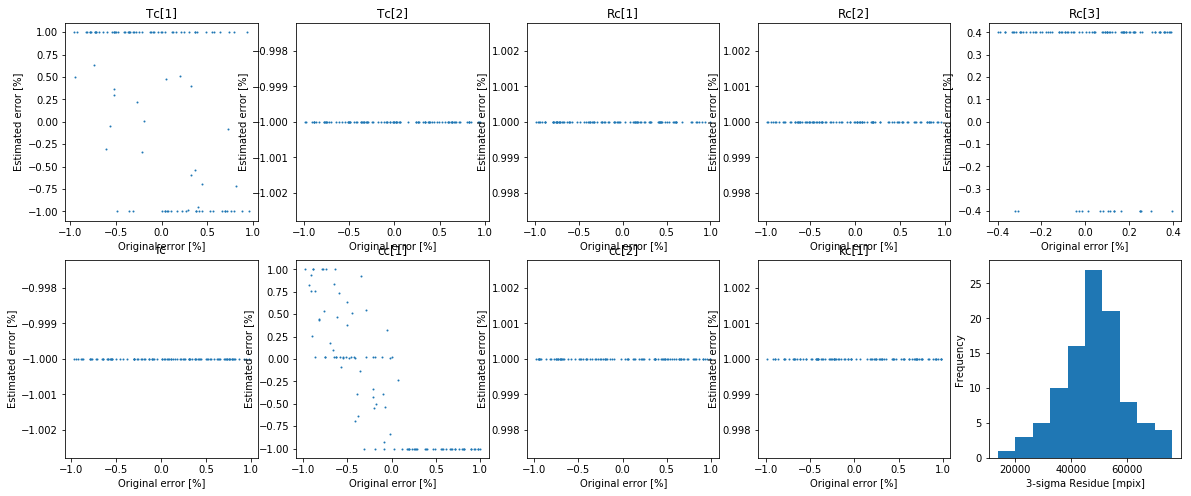

In [60]:
%matplotlib inline

# Get the fiducial choice for camera 1
prefix = "MANIFEST_sim_001_coord_data_camera-1"
params = GetFiducialParameter(prefix)
plateTarget = ReadPlatePos(prefix)

plateFiducial = MakePlateFiducial(100,params.DFOV*0.5,params.ROC)
pixFiducialFid = ConvertPlateToPix(plateFiducial,params)

plateGB = MakeGuideBundle(1000,params.DFOV*0.5,params.ROC)
pixGBFid = ConvertPlateToPix(plateGB,params)

WIDTH,HEIGHT = 2448,2050

plt.clf()
fig,axs = plt.subplots(2,5,figsize=(20,8))
axs = axs.flatten()

# Parameter variations that changes 13 parameters (2 for Tc[], 3 for Rc[], 1 for fc, 5 for kc[], 2 for cc[])
Nvar = 100
randVar = np.random.rand(Nvar,13)*2-1.
randVar[:,4] *= 0.4  # Rc[2] should be far less than 0.4%

arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO = randVar[:,0],randVar[:,1],randVar[:,2],randVar[:,3],randVar[:,4],randVar[:,5],randVar[:,11],randVar[:,12],randVar[:,6]
arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE = [],[],[],[],[],[],[],[],[]

errBudget = []
for rv,ivar in zip(randVar,range(1,Nvar+1)):
    newParams = ChangeFullFiducialParameter(params,rv)
    pixTarget = ConvertPlateToPix(plateTarget,newParams)
    pixFiducial = ConvertPlateToPix(plateFiducial,newParams)
    pixGB = ConvertPlateToPix(plateGB,newParams)
        
    pixFiducialSub = CollectPixWithinFrame(pixFiducial,WIDTH,HEIGHT)
    plateFiducialSub = GetFiducialSubset(plateFiducial,pixFiducialFid,pixFiducialSub)
    
    pixGBSub = CollectPixWithinFrame(pixGB,WIDTH,HEIGHT)
    plateGBSub = GetFiducialSubset(plateGB,pixGBFid,pixGBSub)
    
    plateSub = np.concatenate((plateFiducialSub,plateGBSub))
    pixSub = np.concatenate((pixFiducialSub,pixGBSub))
    
    estParams = RecalibrateParameter(plateSub,pixSub,params)
    arrTcAE.append(estParams.Tc[0]/params.Tc[1]*100)
    arrTcBE.append((estParams.Tc[1]-params.Tc[1])/params.Tc[1]*100)
    arrRcAE.append((estParams.Rc[0]-params.Rc[0])/params.Rc[0]*100)
    arrRcBE.append((estParams.Rc[1]-params.Rc[1])/params.Rc[1]*100)
    arrRcCE.append((estParams.Rc[2]-params.Rc[2])/params.Rc[2]*100)
    arrFcE.append((estParams.fc-params.fc)/params.fc*100)
    arrCcAE.append((estParams.cc[0]-params.cc[0])/params.cc[0]*100)
    arrCcBE.append((estParams.cc[1]-params.cc[1])/params.cc[1]*100)
    arrKcAE.append((estParams.kc[0]-params.kc[0])/params.kc[0]*100)

    estPixTarget = ConvertPlateToPix(plateTarget,estParams)
    residues = np.sqrt((estPixTarget[:,0]-pixTarget[:,0])**2 + (estPixTarget[:,1]-pixTarget[:,1])**2)*1E3
    
    errBudget.append(np.percentile(residues,99.865))


for ax,orig,est,valType in zip(axs[:-1],
                                [arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO],
                              [arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE],
                              ["Tc[1]","Tc[2]","Rc[1]","Rc[2]","Rc[3]","fc","cc[1]","cc[2]","kc[1]"]):
    ax.scatter(orig,est,s=1,rasterized=True)
    ax.set_title(valType)
    ax.set_xlabel("Original error [%]")
    ax.set_ylabel("Estimated error [%]")
    
axs[-1].hist(errBudget)
axs[-1].set_xlabel("3-sigma Residue [mpix]")
axs[-1].set_ylabel("Frequency")
plt.savefig("plateFiducialOnly_1p_noIter_1000bundle.pdf",bbox_inches="tight",dpi=150)

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


<Figure size 432x288 with 0 Axes>

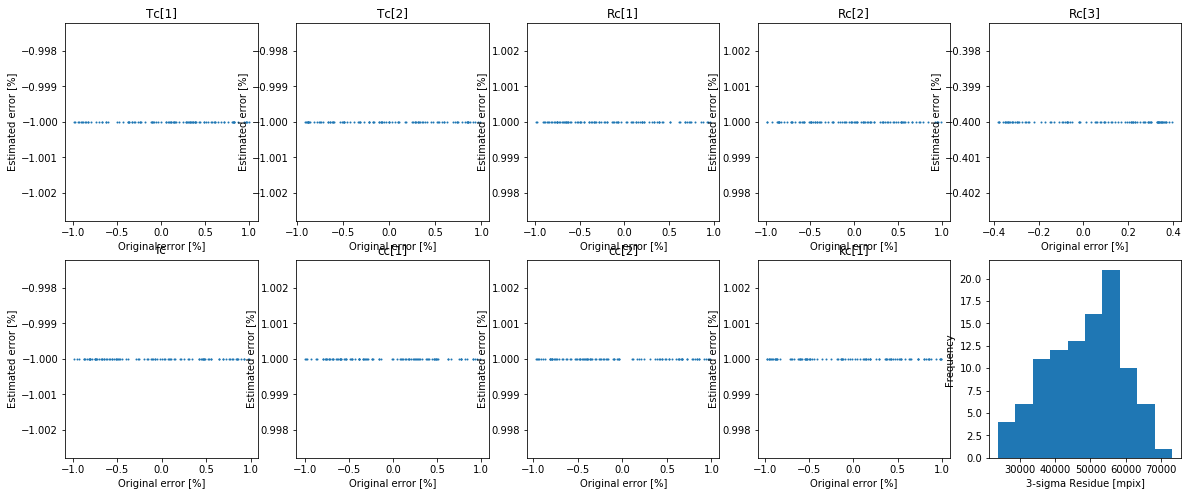

In [62]:
%matplotlib inline

# Get the fiducial choice for camera 1
prefix = "MANIFEST_sim_001_coord_data_camera-1"
params = GetFiducialParameter(prefix)
plateTarget = ReadPlatePos(prefix)

plateFiducial = MakePlateFiducial(100,params.DFOV*0.5,params.ROC)
pixFiducialFid = ConvertPlateToPix(plateFiducial,params)

plateGB = MakeGuideBundle(1000,params.DFOV*0.5,params.ROC)
pixGBFid = ConvertPlateToPix(plateGB,params)

WIDTH,HEIGHT = 2448,2050

plt.clf()
fig,axs = plt.subplots(2,5,figsize=(20,8))
axs = axs.flatten()

# Parameter variations that changes 13 parameters (2 for Tc[], 3 for Rc[], 1 for fc, 5 for kc[], 2 for cc[])
Nvar = 100
randVar = np.random.rand(Nvar,13)*2-1.
randVar[:,4] *= 0.4  # Rc[2] should be far less than 0.4%

arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO = randVar[:,0],randVar[:,1],randVar[:,2],randVar[:,3],randVar[:,4],randVar[:,5],randVar[:,11],randVar[:,12],randVar[:,6]
arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE = [],[],[],[],[],[],[],[],[]

errBudget = []
for rv,ivar in zip(randVar,range(1,Nvar+1)):
    newParams = ChangeFullFiducialParameter(params,rv)
    pixTarget = ConvertPlateToPix(plateTarget,newParams)
    pixFiducial = ConvertPlateToPix(plateFiducial,newParams)
    pixGB = ConvertPlateToPix(plateGB,newParams)
        
    pixFiducialSub = CollectPixWithinFrame(pixFiducial,WIDTH,HEIGHT)
    plateFiducialSub = GetFiducialSubset(plateFiducial,pixFiducialFid,pixFiducialSub)
    
    pixGBSub = CollectPixWithinFrame(pixGB,WIDTH,HEIGHT)
    plateGBSub = GetFiducialSubset(plateGB,pixGBFid,pixGBSub)
    
    plateSub = np.concatenate((plateFiducialSub,plateGBSub))
    pixSub = np.concatenate((pixFiducialSub,pixGBSub))
    
    estParams = RecalibrateParameterCamFirst(plateSub,pixSub,params)
    arrTcAE.append(estParams.Tc[0]/params.Tc[1]*100)
    arrTcBE.append((estParams.Tc[1]-params.Tc[1])/params.Tc[1]*100)
    arrRcAE.append((estParams.Rc[0]-params.Rc[0])/params.Rc[0]*100)
    arrRcBE.append((estParams.Rc[1]-params.Rc[1])/params.Rc[1]*100)
    arrRcCE.append((estParams.Rc[2]-params.Rc[2])/params.Rc[2]*100)
    arrFcE.append((estParams.fc-params.fc)/params.fc*100)
    arrCcAE.append((estParams.cc[0]-params.cc[0])/params.cc[0]*100)
    arrCcBE.append((estParams.cc[1]-params.cc[1])/params.cc[1]*100)
    arrKcAE.append((estParams.kc[0]-params.kc[0])/params.kc[0]*100)

    estPixTarget = ConvertPlateToPix(plateTarget,estParams)
    residues = np.sqrt((estPixTarget[:,0]-pixTarget[:,0])**2 + (estPixTarget[:,1]-pixTarget[:,1])**2)*1E3
    
    errBudget.append(np.percentile(residues,99.865))


for ax,orig,est,valType in zip(axs[:-1],
                                [arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO],
                              [arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE],
                              ["Tc[1]","Tc[2]","Rc[1]","Rc[2]","Rc[3]","fc","cc[1]","cc[2]","kc[1]"]):
    ax.scatter(orig,est,s=1,rasterized=True)
    ax.set_title(valType)
    ax.set_xlabel("Original error [%]")
    ax.set_ylabel("Estimated error [%]")
    
axs[-1].hist(errBudget)
axs[-1].set_xlabel("3-sigma Residue [mpix]")
axs[-1].set_ylabel("Frequency")
plt.savefig("plateFiducialOnly_1p_camFirst_noIter_1000bundle.pdf",bbox_inches="tight",dpi=150)

In [63]:
def RecalibrateParameter(arrPlate,arrPix,paramsFid):
    # Here, let's consider STAGGERED fitting of plate alignment parameters and camera calibration parameters
    # 1. Initialize two types of parameters by using fiducial choice
    plateParam = np.concatenate((paramsFid.Tc[:-1],paramsFid.Rc))
    camParam = np.concatenate((np.array([paramsFid.fc]),paramsFid.kc,paramsFid.cc))
    
    plateParamFid,camParamFid = np.copy(plateParam),np.copy(camParam)
    param = np.concatenate((plateParam,camParam))
    
    plateLowPercent,plateHighPercent = plateParamFid*0.99,plateParamFid*1.01
    camLowPercent,camHighPercent = camParamFid*0.99,camParamFid*1.01
    plateLowBound = np.minimum(plateLowPercent,plateHighPercent) + np.array([-np.abs(paramsFid.Tc[1])*0.01,0,0,0,np.abs(paramsFid.Rc[2]*0.006)])
    plateHighBound = np.maximum(plateLowPercent,plateHighPercent) + np.array([np.abs(paramsFid.Tc[1])*0.01,0,0,0,-np.abs(paramsFid.Rc[2]*0.006)])
    camLowBound = np.minimum(camLowPercent,camHighPercent) + np.array([0,0,-1e-6,-1e-6,-1e-6,-1e-6,0,0])
    camHighBound = np.maximum(camLowPercent,camHighPercent) + np.array([0,0,1e-6,1e-6,1e-6,1e-6,0,0])
    
    # 2. Fit until it converges to something....
    iTrial = 0
    while iTrial < 1000:
        plateParamOld,camParamOld,paramOld = np.copy(plateParam),np.copy(camParam),np.copy(param)
        plateParam = opt.least_squares(ResidueChangePlate,plateParamOld,
                                     args=(arrPlate,arrPix,camParamOld),
                                       bounds=(plateLowBound,plateHighBound),
                                      ftol=1E-16,xtol=1E-16).x
        camParam = opt.least_squares(ResidueChangeCam,camParamOld,
                                    args=(arrPlate,arrPix,plateParam),
                                    bounds=(camLowBound,camHighBound),
                                    ftol=1E-16,xtol=1E-16).x
        iTrial += 1
        param = np.concatenate((plateParam,camParam))
        
        if iTrial < 3:
            continue
        error = np.nanmax(np.abs(param-paramOld)/np.abs(paramOld))
        if error < 1E-6:
            break
        if iTrial % 100 == 0:
            print(" ---> Trial %d : max. parameter error is %f percent" % (iTrial,error*100.))
            
    print(" ---> Trial %d : parameter converged (or maximum trial reached)" % (iTrial))
            
    return ConstructParameter(plateParam,camParam)

def RecalibrateParameterCamFirst(arrPlate,arrPix,paramsFid):
    # Here, let's consider STAGGERED fitting of plate alignment parameters and camera calibration parameters
    # 1. Initialize two types of parameters by using fiducial choice
    plateParam = np.concatenate((paramsFid.Tc[:-1],paramsFid.Rc))
    camParam = np.concatenate((np.array([paramsFid.fc]),paramsFid.kc,paramsFid.cc))
    
    plateParamFid,camParamFid = np.copy(plateParam),np.copy(camParam)
    param = np.concatenate((plateParam,camParam))
    
    plateLowPercent,plateHighPercent = plateParamFid*0.99,plateParamFid*1.01
    camLowPercent,camHighPercent = camParamFid*0.99,camParamFid*1.01
    plateLowBound = np.minimum(plateLowPercent,plateHighPercent) + np.array([-np.abs(paramsFid.Tc[1])*0.01,0,0,0,np.abs(paramsFid.Rc[2])*0.006])
    plateHighBound = np.maximum(plateLowPercent,plateHighPercent) + np.array([np.abs(paramsFid.Tc[1])*0.01,0,0,0,-np.abs(paramsFid.Rc[2])*0.006])
    camLowBound = np.minimum(camLowPercent,camHighPercent) + np.array([0,0,-1e-6,-1e-6,-1e-6,-1e-6,0,0])
    camHighBound = np.maximum(camLowPercent,camHighPercent) + np.array([0,0,1e-6,1e-6,1e-6,1e-6,0,0])
    
    # 2. Fit until it converges to something....
    iTrial = 0
    while iTrial < 1000:
        plateParamOld,camParamOld,paramOld = np.copy(plateParam),np.copy(camParam),np.copy(param)
        camParam = opt.least_squares(ResidueChangeCam,camParamOld,
                                    args=(arrPlate,arrPix,plateParamOld),
                                    bounds=(camLowBound,camHighBound),
                                    ftol=1E-16,xtol=1E-16).x
        plateParam = opt.least_squares(ResidueChangePlate,plateParamOld,
                                     args=(arrPlate,arrPix,camParam),
                                       bounds=(plateLowBound,plateHighBound),
                                      ftol=1E-16,xtol=1E-16).x

        iTrial += 1
        param = np.concatenate((plateParam,camParam))
        
        if iTrial < 3:
            continue
        error = np.nanmax(np.abs(param-paramOld)/np.abs(paramOld))
        if error < 1E-6:
            break
        if iTrial % 100 == 0:
            print(" ---> Trial %d : max. parameter error is %f percent" % (iTrial,error*100.))
            
    print(" ---> Trial %d : parameter converged (or maximum trial reached)" % (iTrial))
            
    return ConstructParameter(plateParam,camParam)

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial r

<Figure size 432x288 with 0 Axes>

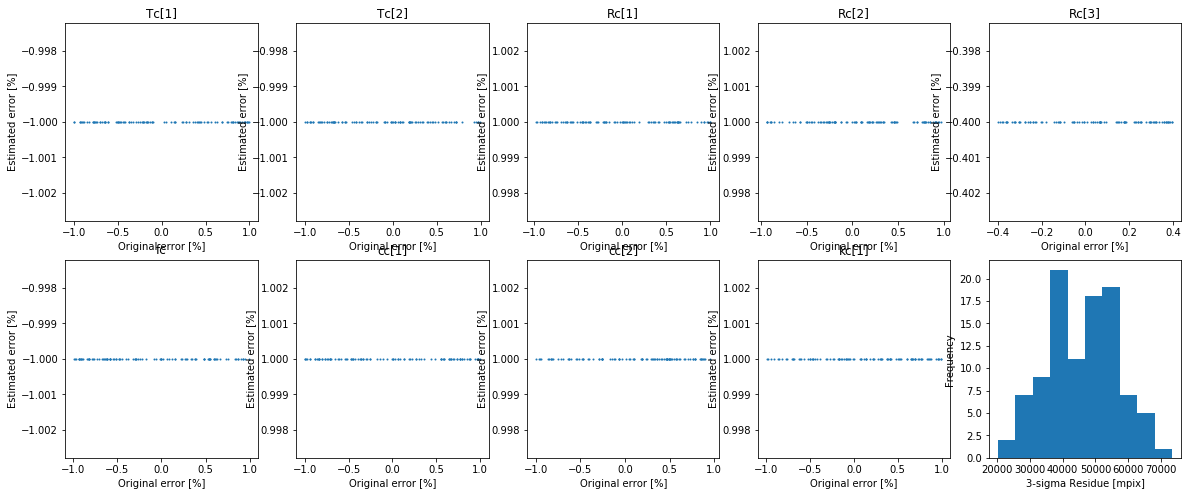

In [64]:
%matplotlib inline

# Get the fiducial choice for camera 1
prefix = "MANIFEST_sim_001_coord_data_camera-1"
params = GetFiducialParameter(prefix)
plateTarget = ReadPlatePos(prefix)

plateFiducial = MakePlateFiducial(100,params.DFOV*0.5,params.ROC)
pixFiducialFid = ConvertPlateToPix(plateFiducial,params)

plateGB = MakeGuideBundle(1000,params.DFOV*0.5,params.ROC)
pixGBFid = ConvertPlateToPix(plateGB,params)

WIDTH,HEIGHT = 2448,2050

plt.clf()
fig,axs = plt.subplots(2,5,figsize=(20,8))
axs = axs.flatten()

# Parameter variations that changes 13 parameters (2 for Tc[], 3 for Rc[], 1 for fc, 5 for kc[], 2 for cc[])
Nvar = 100
randVar = np.random.rand(Nvar,13)*2-1.
randVar[:,4] *= 0.4  # Rc[2] should be far less than 0.4%

arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO = randVar[:,0],randVar[:,1],randVar[:,2],randVar[:,3],randVar[:,4],randVar[:,5],randVar[:,11],randVar[:,12],randVar[:,6]
arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE = [],[],[],[],[],[],[],[],[]

errBudget = []
for rv,ivar in zip(randVar,range(1,Nvar+1)):
    newParams = ChangeFullFiducialParameter(params,rv)
    pixTarget = ConvertPlateToPix(plateTarget,newParams)
    pixFiducial = ConvertPlateToPix(plateFiducial,newParams)
    pixGB = ConvertPlateToPix(plateGB,newParams)
        
    pixFiducialSub = CollectPixWithinFrame(pixFiducial,WIDTH,HEIGHT)
    plateFiducialSub = GetFiducialSubset(plateFiducial,pixFiducialFid,pixFiducialSub)
    
    pixGBSub = CollectPixWithinFrame(pixGB,WIDTH,HEIGHT)
    plateGBSub = GetFiducialSubset(plateGB,pixGBFid,pixGBSub)
    
    plateSub = np.concatenate((plateFiducialSub,plateGBSub))
    pixSub = np.concatenate((pixFiducialSub,pixGBSub))
    
    estParams = RecalibrateParameter(plateSub,pixSub,params)
    arrTcAE.append(estParams.Tc[0]/params.Tc[1]*100)
    arrTcBE.append((estParams.Tc[1]-params.Tc[1])/params.Tc[1]*100)
    arrRcAE.append((estParams.Rc[0]-params.Rc[0])/params.Rc[0]*100)
    arrRcBE.append((estParams.Rc[1]-params.Rc[1])/params.Rc[1]*100)
    arrRcCE.append((estParams.Rc[2]-params.Rc[2])/params.Rc[2]*100)
    arrFcE.append((estParams.fc-params.fc)/params.fc*100)
    arrCcAE.append((estParams.cc[0]-params.cc[0])/params.cc[0]*100)
    arrCcBE.append((estParams.cc[1]-params.cc[1])/params.cc[1]*100)
    arrKcAE.append((estParams.kc[0]-params.kc[0])/params.kc[0]*100)

    estPixTarget = ConvertPlateToPix(plateTarget,estParams)
    residues = np.sqrt((estPixTarget[:,0]-pixTarget[:,0])**2 + (estPixTarget[:,1]-pixTarget[:,1])**2)*1E3
    
    errBudget.append(np.percentile(residues,99.865))


for ax,orig,est,valType in zip(axs[:-1],
                                [arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO],
                              [arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE],
                              ["Tc[1]","Tc[2]","Rc[1]","Rc[2]","Rc[3]","fc","cc[1]","cc[2]","kc[1]"]):
    ax.scatter(orig,est,s=1,rasterized=True)
    ax.set_title(valType)
    ax.set_xlabel("Original error [%]")
    ax.set_ylabel("Estimated error [%]")
    
axs[-1].hist(errBudget)
axs[-1].set_xlabel("3-sigma Residue [mpix]")
axs[-1].set_ylabel("Frequency")
plt.savefig("plateFiducialOnly_1p_1000bundle.pdf",bbox_inches="tight",dpi=150)

C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
C:\Users\redeo\Anaconda3\envs\tensorflow\lib\site-packages\scipy\optimize\_lsq\least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))


 ---> Trial 52 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 3 : parameter converged (or maximum trial reached)
 ---> Trial 100 : max. parameter error is 0.125378 percent
 ---> Trial 200 : max. parameter error is 0.114244 percent
 ---> Trial 300 : max. parameter error is 0.209917 percent
 ---> Trial 400 : max. parameter error is 0.132994 percent
 ---> T

<Figure size 432x288 with 0 Axes>

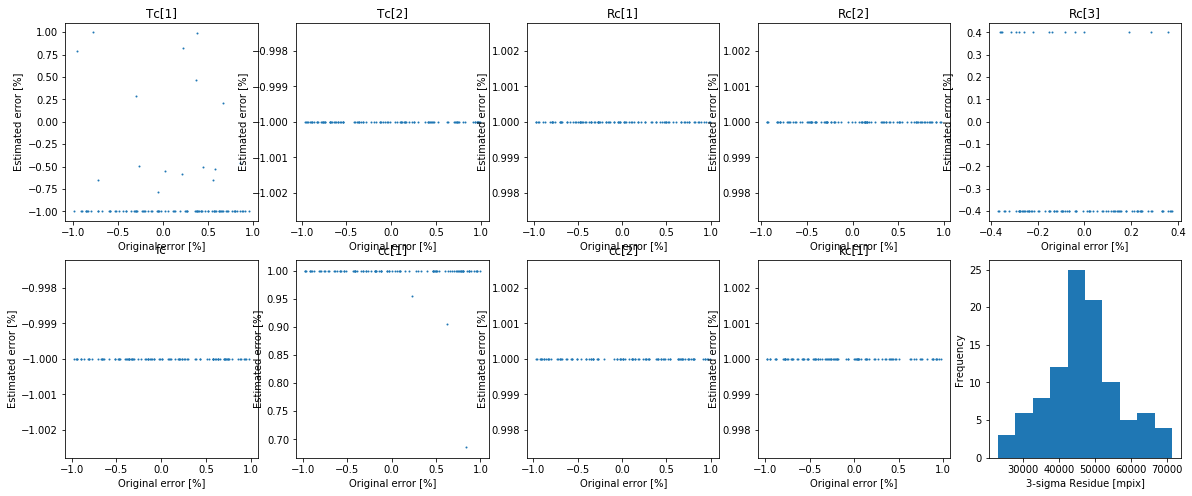

In [65]:
%matplotlib inline

# Get the fiducial choice for camera 1
prefix = "MANIFEST_sim_001_coord_data_camera-1"
params = GetFiducialParameter(prefix)
plateTarget = ReadPlatePos(prefix)

plateFiducial = MakePlateFiducial(100,params.DFOV*0.5,params.ROC)
pixFiducialFid = ConvertPlateToPix(plateFiducial,params)

plateGB = MakeGuideBundle(1000,params.DFOV*0.5,params.ROC)
pixGBFid = ConvertPlateToPix(plateGB,params)

WIDTH,HEIGHT = 2448,2050

plt.clf()
fig,axs = plt.subplots(2,5,figsize=(20,8))
axs = axs.flatten()

# Parameter variations that changes 13 parameters (2 for Tc[], 3 for Rc[], 1 for fc, 5 for kc[], 2 for cc[])
Nvar = 100
randVar = np.random.rand(Nvar,13)*2-1.
randVar[:,4] *= 0.4  # Rc[2] should be far less than 0.4%

arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO = randVar[:,0],randVar[:,1],randVar[:,2],randVar[:,3],randVar[:,4],randVar[:,5],randVar[:,11],randVar[:,12],randVar[:,6]
arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE = [],[],[],[],[],[],[],[],[]

errBudget = []
for rv,ivar in zip(randVar,range(1,Nvar+1)):
    newParams = ChangeFullFiducialParameter(params,rv)
    pixTarget = ConvertPlateToPix(plateTarget,newParams)
    pixFiducial = ConvertPlateToPix(plateFiducial,newParams)
    pixGB = ConvertPlateToPix(plateGB,newParams)
        
    pixFiducialSub = CollectPixWithinFrame(pixFiducial,WIDTH,HEIGHT)
    plateFiducialSub = GetFiducialSubset(plateFiducial,pixFiducialFid,pixFiducialSub)
    
    pixGBSub = CollectPixWithinFrame(pixGB,WIDTH,HEIGHT)
    plateGBSub = GetFiducialSubset(plateGB,pixGBFid,pixGBSub)
    
    plateSub = np.concatenate((plateFiducialSub,plateGBSub))
    pixSub = np.concatenate((pixFiducialSub,pixGBSub))
    
    estParams = RecalibrateParameterCamFirst(plateSub,pixSub,params)
    arrTcAE.append(estParams.Tc[0]/params.Tc[1]*100)
    arrTcBE.append((estParams.Tc[1]-params.Tc[1])/params.Tc[1]*100)
    arrRcAE.append((estParams.Rc[0]-params.Rc[0])/params.Rc[0]*100)
    arrRcBE.append((estParams.Rc[1]-params.Rc[1])/params.Rc[1]*100)
    arrRcCE.append((estParams.Rc[2]-params.Rc[2])/params.Rc[2]*100)
    arrFcE.append((estParams.fc-params.fc)/params.fc*100)
    arrCcAE.append((estParams.cc[0]-params.cc[0])/params.cc[0]*100)
    arrCcBE.append((estParams.cc[1]-params.cc[1])/params.cc[1]*100)
    arrKcAE.append((estParams.kc[0]-params.kc[0])/params.kc[0]*100)

    estPixTarget = ConvertPlateToPix(plateTarget,estParams)
    residues = np.sqrt((estPixTarget[:,0]-pixTarget[:,0])**2 + (estPixTarget[:,1]-pixTarget[:,1])**2)*1E3
    
    errBudget.append(np.percentile(residues,99.865))


for ax,orig,est,valType in zip(axs[:-1],
                                [arrTcAO,arrTcBO,arrRcAO,arrRcBO,arrRcCO,arrFcO,arrCcAO,arrCcBO,arrKcAO],
                              [arrTcAE,arrTcBE,arrRcAE,arrRcBE,arrRcCE,arrFcE,arrCcAE,arrCcBE,arrKcAE],
                              ["Tc[1]","Tc[2]","Rc[1]","Rc[2]","Rc[3]","fc","cc[1]","cc[2]","kc[1]"]):
    ax.scatter(orig,est,s=1,rasterized=True)
    ax.set_title(valType)
    ax.set_xlabel("Original error [%]")
    ax.set_ylabel("Estimated error [%]")
    
axs[-1].hist(errBudget)
axs[-1].set_xlabel("3-sigma Residue [mpix]")
axs[-1].set_ylabel("Frequency")
plt.savefig("plateFiducialOnly_1p_camFirst_1000bundle.pdf",bbox_inches="tight",dpi=150)